### Reading dosage and info

In [3]:
# read plink data all at once
library(genio)
library(repr)
#genotype_dir <- "/gpfs/scratch60/zhao/zy92/GTEX/cis_snp/"
genotype_dir <- "/ysm-gpfs/project/wl382/GTEx_v8/genotype/cis_loc/"
chr_num <- 2
gene_idx <- 1
chr_str <- paste0("chr", chr_num, "/")
gene_vec <- list.files(paste0(genotype_dir, chr_str))


#gene_dir <- paste0(genotype_dir, chr_str, gene_vec[gene_idx], "/", gene_vec[gene_idx])
#genotype_info <- read_plink(gene_dir)

# extract genotypes and annotation tables
#genotype   <- genotype_info$X
#bim <- genotype_info$bim
#fam <- genotype_info$fam

In [4]:
extract_genotype <- function(gene_idx, chr_str, genotype_dir, gene_vec) {
    gene_dir <- paste0(genotype_dir, chr_str, gene_vec[gene_idx], "/", gene_vec[gene_idx])
    genotype_info <- read_plink(gene_dir)
    
    print(paste0("INFO: genotype matrix dimension:", dim(genotype_info$X)[1], " * ", dim(genotype_info$X)[2]))
    return(genotype_info)
}

# extract genotypes and annotation tables
genotype_info <- extract_genotype(1, chr_str, genotype_dir, gene_vec)
genotype   <- genotype_info$X
bim <- genotype_info$bim
fam <- genotype_info$fam


Reading: /ysm-gpfs/project/wl382/GTEx_v8/genotype/cis_loc/chr2/ENSG00000003137.8/ENSG00000003137.8.bim

Reading: /ysm-gpfs/project/wl382/GTEx_v8/genotype/cis_loc/chr2/ENSG00000003137.8/ENSG00000003137.8.fam

Reading: /ysm-gpfs/project/wl382/GTEx_v8/genotype/cis_loc/chr2/ENSG00000003137.8/ENSG00000003137.8.bed



[1] "INFO: genotype matrix dimension:6092 * 838"


### glasso test

In [3]:
# functions
grad_prep <- function(X, Y){
	## pre-calculate some metrics for gradient
	ll = length(Y)
	P = ncol(X[[1]])
	XY = matrix(0,P,ll)
	for(i in 1:ll){
		XY[,i] = t(X[[i]])%*%Y[[i]]/nrow(X[[i]])
	}
	XY
}

cv_helper <- function(N, fold){
	valid_num = floor(N/fold)
	set.seed(123)
	perm = sample(1:N, size = N)
	idx1 = seq(1,N,valid_num)
	idx2 = c(idx1[-1]-1,N)
	list(perm=perm, idx=cbind(idx1,idx2))
}

minmax_lambda <- function(lst){
	max_lam = max(unlist(lapply(lst, function(x){max(x$lambda)})))
	min_lam = min(unlist(lapply(lst, function(x){min(x$lambda)})))
	c(min_lam, max_lam)
}

elastic_net_mse <- function(lst, X_tune, Y_tune, X_test, Y_test){
	P = length(lst)
	M = ncol(X_tune[[1]])
	lam_V = rep(0, P)
	test_res = list()
	test_beta = matrix(0, M, P)
	for(t in 1:P){
		ncv = length(lst[[t]]$lambda)
		tmp_mse = rep(0, ncv)
		for(k in 1:ncv){
			tmp_mse[k] = mean((Y_tune[[t]] - X_tune[[t]]%*%lst[[t]]$glmnet.fit$beta[,k])^2)
		}
		ss = which.min(tmp_mse)
		test_beta[,t] = lst[[t]]$glmnet.fit$beta[,ss]
		lam_V[t] = lst[[t]]$lambda[ss]
		predicted = X_test[[t]]%*%lst[[t]]$glmnet.fit$beta[,ss]
		test_res[[t]] = cbind(Y_test[[t]], predicted)
	}
	list(lam = lam_V, mse = test_res, est = test_beta)
}

multi_mse <- function(theta_est, X_test, Y_test){
	answer = list()
	P = ncol(theta_est)
	for(t in 1:P){
		predicted = X_test[[t]]%*%theta_est[,t]
		answer[[t]] = cbind(Y_test[[t]], predicted)
	}
	answer
}

avg_perm <- function(mse_lst){
	fd = length(mse_lst)
	P = length(mse_lst[[1]])
	rsq = mse = adj_mse = matrix(0, fd, P)
	for(f in 1:fd){
		for(t in 1:P){
			rsq[f,t] = (cor(mse_lst[[f]][[t]])[1,2])^2
			mse[f,t] = mean((mse_lst[[f]][[t]][,1]-mse_lst[[f]][[t]][,2])^2)
			adj_mse[f,t] = mse[f,t]/var(mse_lst[[f]][[t]][,1])
		}
	}
	cbind(apply(rsq, 2, mean), apply(mse, 2, mean), apply(adj_mse, 2, mean))

	#list(rsq = apply(rsq, 2, mean), mse = apply(mse, 2, mean), adj_mse = apply(adj_mse, 2, mean))
}

glasso <- function(X, Y, X1, Y1, XX, XY, Xnorm, lambda1, lambda2, theta, stepsize = 1e-4, maxiter = 250, eps = 1e-4){
	bgt = Sys.time()
	M = nrow(XY)
	P = length(X)
	NN = unlist(lapply(X, nrow))
	old_objV1 = 0
	for(t in 1:P){
		old_objV1 = old_objV1 + 1/2*mean((Y[[t]]-X[[t]]%*%theta[,t])^2)
	}
	IRdisplay::display_html(paste0("Training error: ", old_objV1, '\n'))
	old_objV2 = 0
	for(t in 1:P){
		old_objV2 = old_objV2 + 1/2*mean((Y1[[t]]-X1[[t]]%*%theta[,t])^2)
	}
	IRdisplay::display_html(paste0("Testing error: ", old_objV2, '\n'))
	beta_j_lasso = rep(0, P)
	tmp_XYj = 0
	if(!is.loaded("wrapper")){
		dyn.load("/ysm-gpfs/pi/zhao/from_louise/yh367/GTEX/codes/glasso.so")
	}
    
	for(i in 1:maxiter){
		bgt = Sys.time()
		res = .Call("wrapper", XX, XY, theta, M, P, beta_j_lasso, lambda1, lambda2, Xnorm)
		edt = Sys.time()
		#print(edt-bgt)
		new_objV1 = new_objV2 = 0
		for(t in 1:P){
			new_objV1 = new_objV1 + 1/2*mean((Y[[t]]-X[[t]]%*%theta[,t])^2)
            #IRdisplay::display_html(sum(is.na(X[[t]])))
            #IRdisplay::display_html(sum(is.na(Y[[t]])))
		}
		IRdisplay::display_html(paste0("Training error: ", new_objV1, '\n'))
		for(t in 1:P){
			new_objV2 = new_objV2 + 1/2*mean((Y1[[t]]-X1[[t]]%*%theta[,t])^2)
            #IRdisplay::display_html(sum(is.na(X[[t]])))
            #IRdisplay::display_html(sum(is.na(Y[[t]])))
		}
		IRdisplay::display_html(paste0("Testing error: ", new_objV2, '\n'))
		if(new_objV2 > old_objV2|new_objV1 > old_objV1){
			break
		}else{
			old_objV2 = new_objV2
		}
		if(abs(new_objV1-old_objV1) < eps){
			break
		}else{
			old_objV1 = new_objV1
		}
	}
	#edt = Sys.time()
	#print(edt-bgt)
	list(est = theta, tune_err = new_objV2)
}

glasso_no_early_stopping <- function(X, Y, XX, XY, Xnorm, lambda1, lambda2, theta, stepsize = 1e-4, maxiter = 250, eps = 1e-3){
	M = nrow(XY)
	P = length(X)
	NN = unlist(lapply(X, nrow))
	old_objV1 = 0
	for(t in 1:P){
		old_objV1 = old_objV1 + 1/2*mean((Y[[t]]-X[[t]]%*%theta[,t])^2)
	}
	IRdisplay::display_html(paste0("Training error: ", old_objV1, '\n'))
	beta_j_lasso = rep(0, P)
	tmp_XYj = 0
	if(!is.loaded("wrapper")){
		dyn.load("/ysm-gpfs/pi/zhao/from_louise/yh367/GTEX/codes/glasso.so")
	}
	for(i in 1:maxiter){
		res = .Call("wrapper", XX, XY, theta, M, P, beta_j_lasso, lambda1, lambda2, Xnorm)
		new_objV1 = 0
		for(t in 1:P){
			new_objV1 = new_objV1 + 1/2*mean((Y[[t]]-X[[t]]%*%theta[,t])^2)
		}
		IRdisplay::display_html(paste0("Training error: ", new_objV1, '\n'))
		if(abs(new_objV1-old_objV1) < eps|new_objV1 > old_objV1){
			break
		}else{
			old_objV1 = new_objV1
		}
	}
	list(est = theta, train_err = new_objV1)
}

In [4]:
### command line input ###
# chr = as.numeric(args[1])
# k = as.numeric(args[2])
# gene_id = args[3]
### data import ###
options(stringsAsFactors=F)
library(glmnet)
library(foreach)
library(genio)
ntune = 100

genotype_dir <- "/ysm-gpfs/project/wl382/GTEx_v8/genotype/cis_loc/"
chr <- 2
gene_idx <- 1
chr_str <- paste0("chr", chr, "/")
gene_vec <- list.files(paste0(genotype_dir, chr_str))
gene_id = gene_vec[gene_idx]
gtex_dir = "/gpfs/loomis/project/zhao/zy92/GTEX/" 
glist = dir(paste0(gtex_dir, "adjusted_expr/chr", chr))
g = glist[gene_idx]

### format for dose and info
# dose:
# GTEX-P4PP-0004-SM-2H2WW->GTEX-P4PP-0004-SM-2H2WW        DOSE    0.000   0.014   0.000   0.000   0.000
# info:
# SNP     REF(0)  ALT(1)  ALT_Frq MAF     AvgCall Rsq     Genotyped       LooRsq  EmpR    EmpRsq  Dose0   Dose1
# 1_157695412_G_A_b37     G       A       -               -       -       Typed_Only      -       -
#       -       -       -

dose_path = paste0(genotype_dir, chr_str, gene_id, "/", gene_id)
#info_path = paste0(gtex_dir, "cis_snp/chr", chr, "/", g, "/", g, ".mach.info")
Yt = dir(paste0(gtex_dir, "adjusted_expr/", chr_str, g, "/"))
P = length(Yt)

output_dir = "/gpfs/loomis/project/zhao/zy92/GTEX/output/" 

Loading required package: Matrix

Loading required package: foreach

Loaded glmnet 2.0-13




In [5]:
paste0(gtex_dir, "adjusted_expr/", chr_str, g, "/")
length(dir(paste0(gtex_dir, "adjusted_expr/", chr_str, g, "/")))

[1] "/gpfs/loomis/project/zhao/zy92/GTEX/adjusted_expr/chr2/ENSG00000003137/"

[1] 49

In [6]:
genotype_info$X[1:6, 1:6]

,GTEX-1117F,GTEX-111CU,GTEX-111FC,GTEX-111VG,GTEX-111YS,GTEX-1122O
chr2_71129368_C_T_b38,0,0,0,0,0,0
chr2_71129592_A_T_b38,0,0,0,1,0,0
chr2_71130065_C_A_b38,0,0,0,0,0,0
chr2_71130287_C_A_b38,2,1,0,0,0,0
chr2_71130375_C_T_b38,0,0,0,0,0,0
chr2_71130504_C_T_b38,2,1,0,0,0,0


In [7]:
fold = 5
cv_config = cv_helper(450, fold)
#cv_config

In [8]:
output_dir = "/gpfs/loomis/project/zhao/zy92/GTEX/output/" 
output_dir

[1] "/gpfs/loomis/project/zhao/zy92/GTEX/output/"

In [9]:
# create dirs
dir.create(paste0(output_dir, "chr", chr), showWarnings = FALSE)
dir.create(paste0(output_dir, "chr", chr, "/", gene_id), showWarnings = FALSE)
setwd(paste0(output_dir, "chr", chr, "/", gene_id))

# expr files #
Y = list()
for(t in 1:P){
    Y[[t]] = read.table(paste0(gtex_dir, "adjusted_expr/chr", chr, "/", g, "/", Yt[t]), header=F)
}
ssize = unlist(lapply(Y, nrow))
T_num = length(Yt)

In [10]:
dim(Y[[1]])
head(Y[[1]])
dim(Y[[2]])
head(Y[[2]])


[1] 581   2

,V1,V2
,<chr>,<dbl>
1,GTEX-1117F-0226-SM-5GZZ7,4.0936066
2,GTEX-111CU-1826-SM-5GZYN,-1.0074211
3,GTEX-111FC-0226-SM-5N9B8,-0.4055381
4,GTEX-111VG-2326-SM-5N9BK,-2.0799690
5,GTEX-111YS-2426-SM-5GZZQ,-1.2280953
6,GTEX-1122O-2026-SM-9YFMG,-12.2196476


[1] 469   2

,V1,V2
,<chr>,<dbl>
1,GTEX-1117F-1326-SM-5EGHH,-0.3940534
2,GTEX-111CU-1026-SM-5EGIL,-4.1389252
3,GTEX-111YS-1326-SM-5EGGK,5.4606376
4,GTEX-1122O-0926-SM-9YFLC,-10.4655364
5,GTEX-1128S-0926-SM-5GZZU,12.5853893
6,GTEX-113JC-0726-SM-5GZZR,-6.0499574


In [11]:
## genotype files ##
	
    genotype_info <- read_plink(dose_path)
    dose = genotype_info$X
    dose_std = dose
	for(j in 1:nrow(dose)){
		dose_std[j, is.na(dose[j, ])] <- mean(dose[j, ], na.rm = T)
        dose_std[j, ] <- dose_std[j, ] - mean(dose[j, ], na.rm = T)
	}
	print("INFO: section A")
	## covariance matrix ##
    n_sample = ncol(dose_std)
	tmp = as.matrix(dose_std)
	XX = t(tmp)%*%as.matrix(tmp)/n_sample
	Xnorm = diag(XX)
	remove(tmp)
    remove(XX)
	sub_id = colnames(dose_std)
	M = nrow(dose_std)
	sub_id_map = list()
    sub_id_map_exp = list()
	for(t in 1:T_num){
    #for(t in 1:1){
		#tmp = rep(0, nrow(Y[[t]]))
        exp_id <- as.character(sapply(Y[[t]][,1], function(x) substr(x, 1, 10)))
        #print(head(exp_id))
        # index of ids that have matched genotypes 
        # exp_id based on order of exp_id
        match_id <- match(exp_id, sub_id)
		sub_id_map[[t]] <- na.omit(match_id)
        sub_id_map_exp[[t]] <- !is.na(match_id)  
        #print(length(sub_id_map[[t]]))
        #print(sum(sub_id_map_exp[[t]]))
        #for(j in 1:length(tmp)){
            # extract the id starting GTEX-xxxxx
            
			#tmp[j] = which(sub_id==exp_id)
		#}
		#sub_id_map[[t]] = tmp
	}

Reading: /ysm-gpfs/project/wl382/GTEx_v8/genotype/cis_loc/chr2/ENSG00000003137.8/ENSG00000003137.8.bim

Reading: /ysm-gpfs/project/wl382/GTEx_v8/genotype/cis_loc/chr2/ENSG00000003137.8/ENSG00000003137.8.fam

Reading: /ysm-gpfs/project/wl382/GTEx_v8/genotype/cis_loc/chr2/ENSG00000003137.8/ENSG00000003137.8.bed



[1] "INFO: section A"


In [12]:
fold = 5
print("INFO: section B")
cv_config = cv_helper(n_sample, fold)
cv_perm = cv_config$perm
cv_idx = cv_config$idx

single_res_test = list()
single_lam = matrix(0,5,P)
single_theta_est = list()

multi_res_test = list()
multi_lam = rep(0,5)
multi_theta_est = list()

[1] "INFO: section B"


In [13]:
#for(f in 1:fold){
for(f in 1:1){
    # one fold 
    bgt = Sys.time()
    IRdisplay::display_html(paste0("INFO: fold ", f))
    test_index = cv_perm[cv_idx[f,1]:cv_idx[f,2]]
    test_id = sub_id[test_index]

    # move the tuning idx to another idx block
    tuning_index = cv_perm[cv_idx[f%%fold+1,1]:cv_idx[f%%fold+1,2]]
    tuning_id = sub_id[tuning_index]

    # idx list
    X_test = list()
    Y_test = list()
    X_tune = list()
    Y_tune = list()
    X_train = list()
    Y_train = list()
    for(t in 1:T_num){
        # idx matching  
        id_filter = !(sub_id_map[[t]]%in%c(test_index,tuning_index))
        X_train_tmp = sub_id_map[[t]][id_filter]
        Y_train_tmp = which(sub_id_map_exp[[t]] == T)[id_filter]
        tuning_id_filter = sub_id_map[[t]]%in%tuning_index
        X_tuning_tmp = sub_id_map[[t]][tuning_id_filter]
        Y_tuning_tmp = which(sub_id_map_exp[[t]] == T)[tuning_id_filter]
        testing_id_filter = sub_id_map[[t]]%in%test_index
        X_test_tmp = sub_id_map[[t]][testing_id_filter]
        Y_test_tmp = which(sub_id_map_exp[[t]] == T)[testing_id_filter]
        # training data
        X_train[[t]] = apply(as.matrix(dose_std[,X_train_tmp]),1,as.numeric)
        Y_train[[t]] = Y[[t]][Y_train_tmp, 2]
        X_tune[[t]] = apply(as.matrix(dose_std[,X_tuning_tmp]),1,as.numeric)
        Y_tune[[t]] = Y[[t]][Y_tuning_tmp, 2]
        X_test[[t]] = apply(as.matrix(dose_std[,X_test_tmp]),1,as.numeric)
        Y_test[[t]] = Y[[t]][Y_test_tmp, 2]
        #IRdisplay::display_html(length(X_train_tmp))
        #IRdisplay::display_html(length(Y_train_tmp))
        #IRdisplay::display_html(dim(X_train[[t]]))
        #IRdisplay::display_html(length(Y_train[[t]]))
    }

    ## model training ##	
    ## train elastic net and used average lambda as tuning parameters ##
    single_initial_est = matrix(0, ncol(X_train[[1]]), T_num)
    single_summary = list()
    for(t in 1:T_num){
        #print(Y_train[[t]])
        #print(sum(is.na(X_train[[t]])))
        IRdisplay::display_html(paste0("INFO: glmnet cv tissue", t))
        tt = cv.glmnet(X_train[[t]], Y_train[[t]], alpha = 0.5, nfolds = 5)
        single_summary[[t]] = tt
        single_initial_est[,t] = tt$glmnet.fit$beta[,which.min(tt$cvm)]
    }
    ## performance of Elastic net on tuning and testing data with various tuning parameters
    els_output = elastic_net_mse(single_summary, X_tune, Y_tune, X_test, Y_test)
    single_res_test[[f]] = els_output$mse
    single_lam[f,] = els_output$lam
    single_theta_est[[f]] = els_output$est
    remove(els_output)

    initial_numeric = as.numeric(single_initial_est)
    lam_range = minmax_lambda(single_summary)
    lam_V = seq(lam_range[1], lam_range[2], length.out = ntune)
    remove(single_summary)
    remove(single_initial_est)

    ## preparation
    XY = grad_prep(X_train, Y_train)
#		bgt = Sys.time()
    XX_train = lapply(X_train, function(x){t(x)%*%x/nrow(x)})
#		edt = Sys.time()
#		print(edt-bgt)


    res_tune = rep(0, ntune)
    best.lam = 0

#		bgt = Sys.time()
    IRdisplay::display_html(paste0("INFO: tuning "))
    for(lam in 1:ntune){
        single_est = matrix(initial_numeric, M, P)
        ans = glasso(X=X_train, Y=Y_train, X1=X_tune, Y1=Y_tune, XX=XX_train, XY=XY, Xnorm=Xnorm, lambda1=lam_V[lam], lambda2=lam_V[lam], theta=single_est)
        res_tune[lam] = ans$tune_err
        remove(single_est); remove(ans);
    }
#		edt = Sys.time()
#		print(edt-bgt)

    best.lam = lam_V[which.min(res_tune)]
    single_est = matrix(initial_numeric, M, P)
    ans = glasso(X=X_train, Y=Y_train, X1=X_tune, Y1=Y_tune, XX=XX_train, XY=XY, Xnorm=Xnorm, lambda1=best.lam, lambda2=best.lam, theta=single_est)
    multi_res_test[[f]] = multi_mse(ans$est, X_test, Y_test)
    multi_lam[f] = best.lam
    multi_theta_est[[f]] = ans$est
    remove(single_est)
    remove(ans)
    edt = Sys.time()
    print(edt-bgt)
}

INFO: fold 1

INFO: glmnet cv tissue1

INFO: glmnet cv tissue2

INFO: glmnet cv tissue3

INFO: glmnet cv tissue4

INFO: glmnet cv tissue5

INFO: glmnet cv tissue6

INFO: glmnet cv tissue7

INFO: glmnet cv tissue8

INFO: glmnet cv tissue9

INFO: glmnet cv tissue10

INFO: glmnet cv tissue11

INFO: glmnet cv tissue12

INFO: glmnet cv tissue13

INFO: glmnet cv tissue14

INFO: glmnet cv tissue15

INFO: glmnet cv tissue16

INFO: glmnet cv tissue17

INFO: glmnet cv tissue18

INFO: glmnet cv tissue19

INFO: glmnet cv tissue20

INFO: glmnet cv tissue21

INFO: glmnet cv tissue22

INFO: glmnet cv tissue23

INFO: glmnet cv tissue24

INFO: glmnet cv tissue25

INFO: glmnet cv tissue26

INFO: glmnet cv tissue27

INFO: glmnet cv tissue28

INFO: glmnet cv tissue29

INFO: glmnet cv tissue30

INFO: glmnet cv tissue31

INFO: glmnet cv tissue32

INFO: glmnet cv tissue33

INFO: glmnet cv tissue34

INFO: glmnet cv tissue35

INFO: glmnet cv tissue36

INFO: glmnet cv tissue37

INFO: glmnet cv tissue38

INFO: glmnet cv tissue39

INFO: glmnet cv tissue40

INFO: glmnet cv tissue41

INFO: glmnet cv tissue42

INFO: glmnet cv tissue43

INFO: glmnet cv tissue44

INFO: glmnet cv tissue45

INFO: glmnet cv tissue46

INFO: glmnet cv tissue47

INFO: glmnet cv tissue48

INFO: glmnet cv tissue49

INFO: tuning

Training error: 787.928110082842

Testing error: 989.803739515436

Training error: NaN

Testing error: NaN

ERROR: Error in if (new_objV2 > old_objV2 | new_objV1 > old_objV1) {: missing value where TRUE/FALSE needed


In [ ]:
glasso <- function(X, Y, X1, Y1, XX, XY, Xnorm, lambda1, lambda2, theta, stepsize = 1e-4, maxiter = 250, eps = 1e-4){
	bgt = Sys.time()
	M = nrow(XY)
	P = length(X)
	NN = unlist(lapply(X, nrow))
	old_objV1 = 0
	for(t in 1:P){
		old_objV1 = old_objV1 + 1/2*mean((Y[[t]]-X[[t]]%*%theta[,t])^2)
	}
	IRdisplay::display_html(paste0("Training error: ", old_objV1, '\n'))
	old_objV2 = 0
	for(t in 1:P){
		old_objV2 = old_objV2 + 1/2*mean((Y1[[t]]-X1[[t]]%*%theta[,t])^2)
	}
	IRdisplay::display_html(paste0("Testing error: ", old_objV2, '\n'))
	beta_j_lasso = rep(0, P)
	tmp_XYj = 0
	if(!is.loaded("wrapper")){
		dyn.load("/ysm-gpfs/pi/zhao/from_louise/yh367/GTEX/codes/glasso.so")
        #dyn.load("/ysm-gpfs/pi/zhao/zy92/projects/utmost_update/CTIMP/optim.so")
	}
    
	for(i in 1:maxiter){
		bgt = Sys.time()
		res = .Call("wrapper", XX, XY, theta, M, P, beta_j_lasso, lambda1, lambda2, Xnorm)
		edt = Sys.time()
		#print(edt-bgt)
        IRdisplay::display_html(theta[1:6, 1:6])
		new_objV1 = new_objV2 = 0
		for(t in 1:P){
			new_objV1 = new_objV1 + 1/2*mean((Y[[t]]-X[[t]]%*%theta[,t])^2)
            #IRdisplay::display_html(sum(is.na(X[[t]])))
            #IRdisplay::display_html(sum(is.na(Y[[t]])))
            IRdisplay::display_html(theta[,t])
		}
		IRdisplay::display_html(paste0("Training error: ", new_objV1, '\n'))
		for(t in 1:P){
			new_objV2 = new_objV2 + 1/2*mean((Y1[[t]]-X1[[t]]%*%theta[,t])^2)
            #IRdisplay::display_html(sum(is.na(X[[t]])))
            #IRdisplay::display_html(sum(is.na(Y[[t]])))
            IRdisplay::display_html(theta[,t])
		}
		IRdisplay::display_html(paste0("Testing error: ", new_objV2, '\n'))
		if(new_objV2 > old_objV2|new_objV1 > old_objV1){
			break
		}else{
			old_objV2 = new_objV2
		}
		if(abs(new_objV1-old_objV1) < eps){
			break
		}else{
			old_objV1 = new_objV1
		}
	}
	#edt = Sys.time()
	#print(edt-bgt)
	list(est = theta, tune_err = new_objV2)
}

In [ ]:
class(Xnorm)
length(Xnorm)

In [ ]:
sum(is.na(Xnorm))

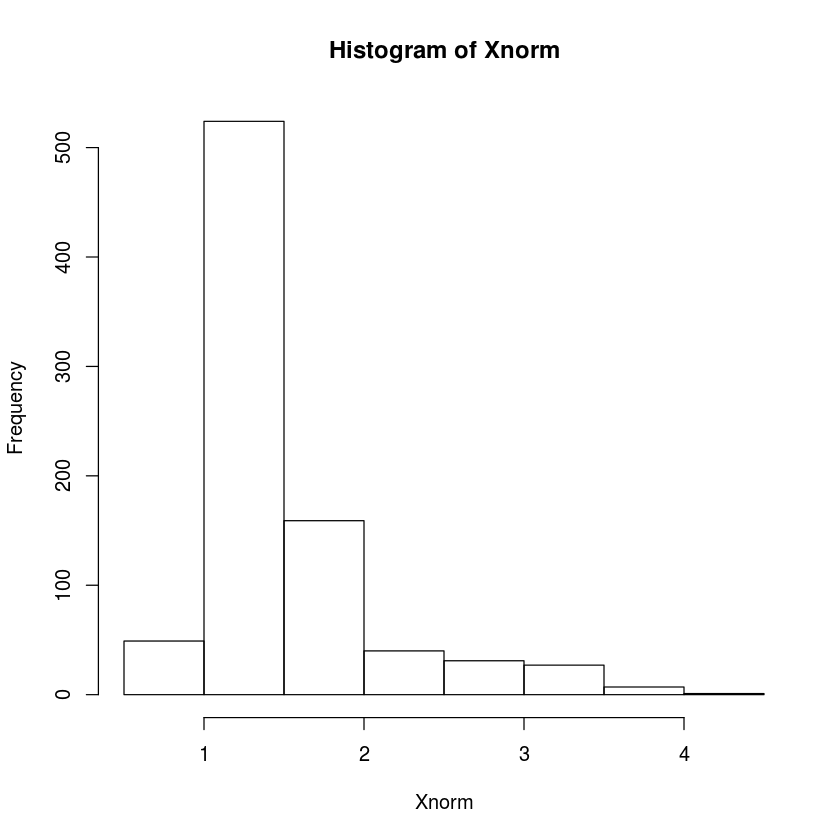

In [20]:
hist(Xnorm)

In [22]:
length(Xnorm)
min(Xnorm)

[1] 838

[1] 0.8709899

In [ ]:
class(XY)
dim(XY)

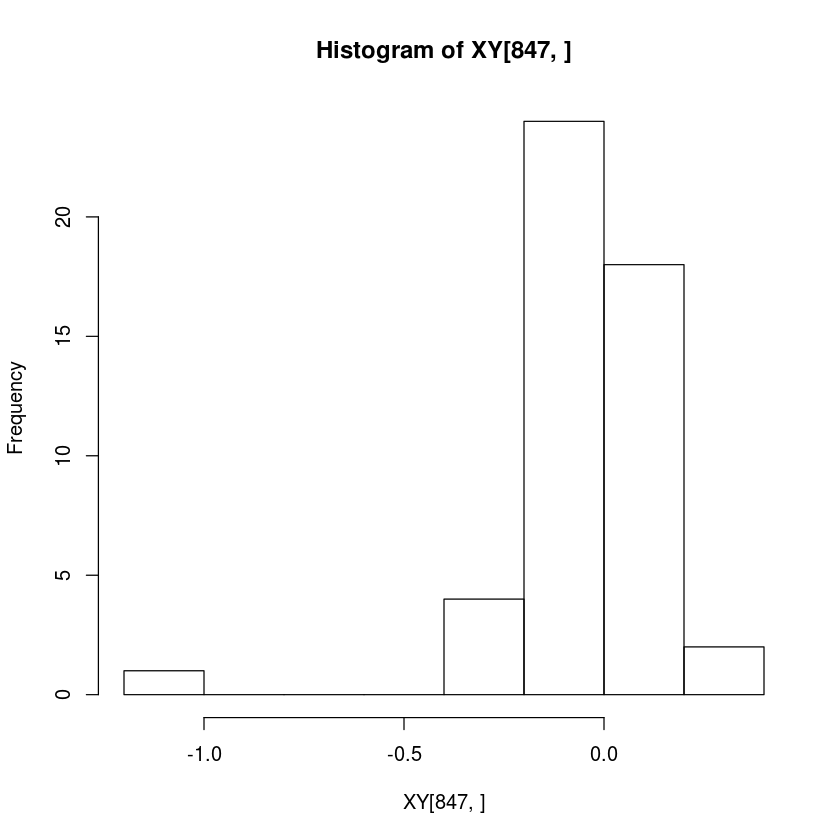

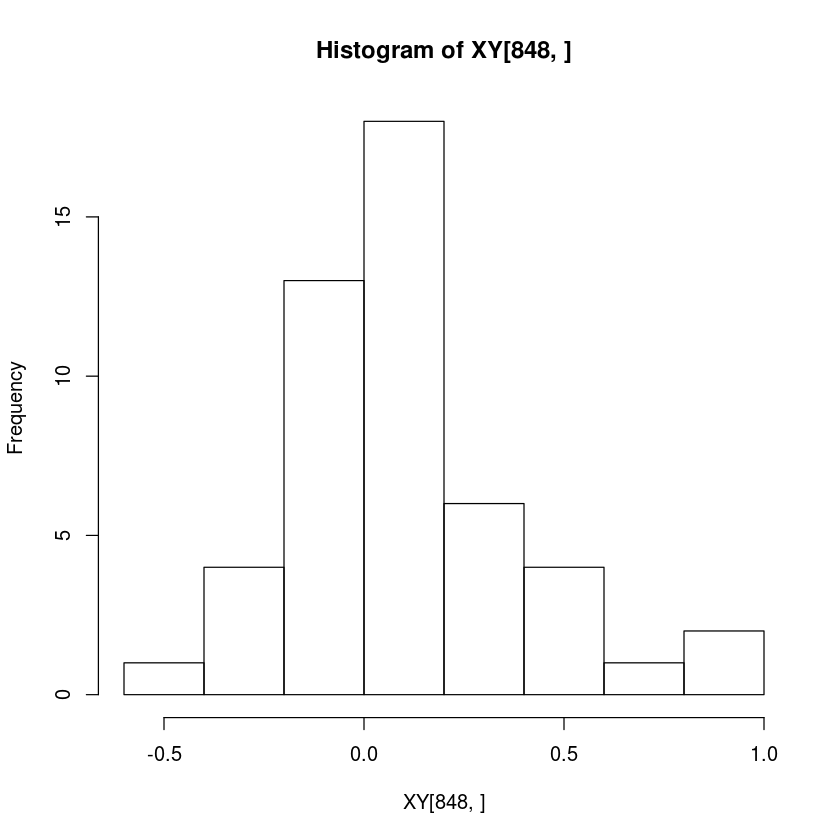

In [23]:
hist(XY[847, ])
hist(XY[848, ])

In [ ]:
sum(is.na(XY[847, ]))
sum(is.na(XY[848, ]))

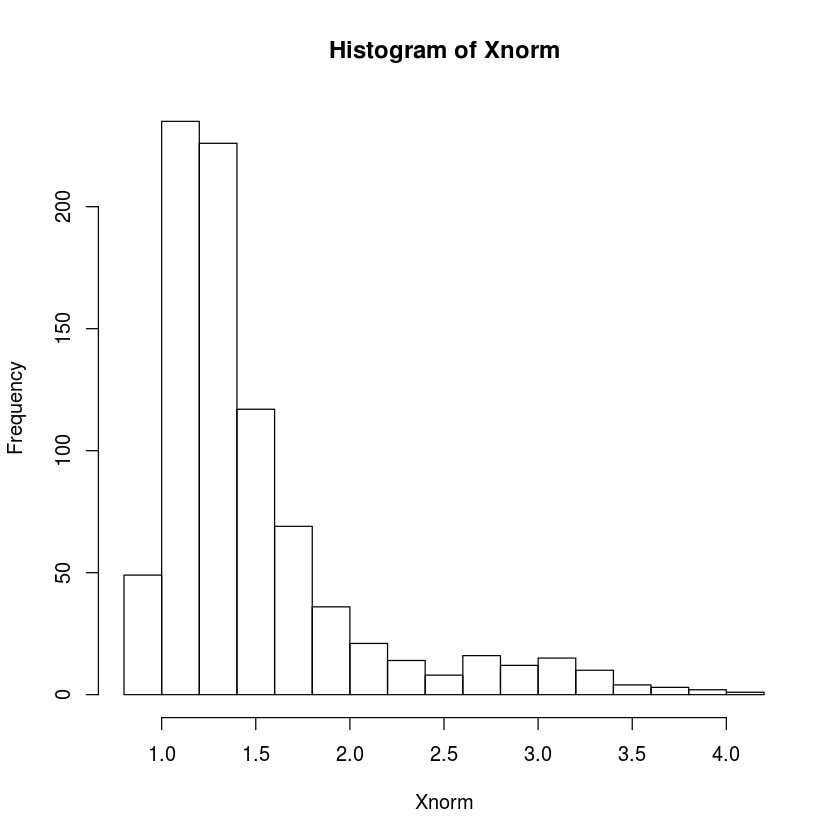

In [14]:
hist(Xnorm, breaks = 20)

# Debugging 

In [14]:
getwd()

[1] "/gpfs/loomis/project/zhao/zy92/GTEX/output/chr2/ENSG00000003137.8"

In [17]:
save(X_train, Y_train, X_tune, Y_tune, XX_train, XY, Xnorm, lam_V, initial_numeric, single_est, 
    X, file = "/gpfs/loomis/project/zhao/zy92/GTEX/output/training_preparation_data_chr2_1.RData")

In [18]:
ln <- load("/gpfs/loomis/project/zhao/zy92/GTEX/output/training_preparation_data_chr2_1.RData")
ln


[1] "X_train"         "Y_train"         "X_tune"          "Y_tune"         
 [5] "XX_train"        "XY"              "Xnorm"           "lam_V"          
 [9] "initial_numeric" "single_est"      "X"

In [27]:
# parameters
lam = 1
X=X_train
Y=Y_train
X1=X_tune
Y1=Y_tune
XX=XX_train
XY=XY
Xnorm=Xnorm
lambda1=lam_V[lam]
lambda2=lam_V[lam]
single_est = matrix(initial_numeric, M, P)
theta=single_est
maxiter = 10

# wrapper function 
dyn.load("/ysm-gpfs/pi/zhao/zy92/projects/utmost_update/CTIMP/optim.so")

bgt = Sys.time()
M = nrow(XY)
P = length(X)
NN = unlist(lapply(X, nrow))
old_objV1 = 0
for(t in 1:P){
    old_objV1 = old_objV1 + 1/2*mean((Y[[t]]-X[[t]]%*%theta[,t])^2)
}
IRdisplay::display_html(paste0("Training error: ", old_objV1, '\n'))
old_objV2 = 0
for(t in 1:P){
    old_objV2 = old_objV2 + 1/2*mean((Y1[[t]]-X1[[t]]%*%theta[,t])^2)
}
IRdisplay::display_html(paste0("Testing error: ", old_objV2, '\n'))
beta_j_lasso = rep(0, P)
beta_j_lasso_matrix = rep(0, M*P)
output_res = rep(0, P)
tmp_XYj = 0

for(i in 1:maxiter){
    bgt = Sys.time()
    res = .Call("wrapper", XX, XY, theta, M, P, beta_j_lasso, beta_j_lasso_matrix, lambda1, lambda2, Xnorm, output_res)
    #IRdisplay::display_html(res)
    edt = Sys.time()
    #print(edt-bgt)
    IRdisplay::display_html(beta_j_lasso)
    #IRdisplay::display_html(theta[1:6, 1:6])
    new_objV1 = new_objV2 = 0
    for(t in 1:P){
        if (theta[])
        new_objV1 = new_objV1 + 1/2*mean((Y[[t]]-X[[t]]%*%theta[,t])^2)
        #IRdisplay::display_html(sum(is.na(X[[t]])))
        #IRdisplay::display_html(sum(is.na(Y[[t]])))
        #IRdisplay::display_html(theta[,t])
    }
    IRdisplay::display_html(paste0("Training error: ", new_objV1, '\n'))
    for(t in 1:P){
        new_objV2 = new_objV2 + 1/2*mean((Y1[[t]]-X1[[t]]%*%theta[,t])^2)
        #IRdisplay::display_html(sum(is.na(X[[t]])))
        #IRdisplay::display_html(sum(is.na(Y[[t]])))
        #IRdisplay::display_html(theta[,t])
    }
    IRdisplay::display_html(paste0("Testing error: ", new_objV2, '\n'))
    if(new_objV2 > old_objV2|new_objV1 > old_objV1){
        break
    }else{
        old_objV2 = new_objV2
    }
    if(abs(new_objV1-old_objV1) < eps){
        break
    }else{
        old_objV1 = new_objV1
    }
}
#edt = Sys.time()
#print(edt-bgt)
#list(est = theta, tune_err = new_objV2)

Training error: 787.928110082842

Testing error: 989.803739515436

Warning message in if (theta[]) new_objV1 = new_objV1 + 1/2 * mean((Y[[t]] - X[[t]] %*% :
“the condition has length > 1 and only the first element will be used”
Warning message in if (theta[]) new_objV1 = new_objV1 + 1/2 * mean((Y[[t]] - X[[t]] %*% :
“the condition has length > 1 and only the first element will be used”
Warning message in if (theta[]) new_objV1 = new_objV1 + 1/2 * mean((Y[[t]] - X[[t]] %*% :
“the condition has length > 1 and only the first element will be used”
Warning message in if (theta[]) new_objV1 = new_objV1 + 1/2 * mean((Y[[t]] - X[[t]] %*% :
“the condition has length > 1 and only the first element will be used”
Warning message in if (theta[]) new_objV1 = new_objV1 + 1/2 * mean((Y[[t]] - X[[t]] %*% :
“the condition has length > 1 and only the first element will be used”
Warning message in if (theta[]) new_objV1 = new_objV1 + 1/2 * mean((Y[[t]] - X[[t]] %*% :
“the condition has length > 1 and only the first element will be used”
Warning message in if (theta[]) ne

Training error: 0

Testing error: NaN

ERROR: Error in if (new_objV2 > old_objV2 | new_objV1 > old_objV1) {: missing value where TRUE/FALSE needed


In [28]:
length(beta_j_lasso_matrix)


[1] 298508

In [30]:
beta_j_lasso_matrix_test <- matrix(beta_j_lasso_matrix, M, P)

In [36]:
sum(is.na(beta_j_lasso_matrix))

[1] 0

In [39]:
sum(is.infinite(beta_j_lasso_matrix))

[1] 49

In [30]:
beta_j_lasso_matrix_test <- matrix(beta_j_lasso_matrix, M, P)

In [36]:
sum(is.na(beta_j_lasso_matrix))

[1] 0

In [39]:
sum(is.infinite(beta_j_lasso_matrix))

[1] 49

In [40]:
which(is.infinite(beta_j_lasso_matrix))

[1]    842   6934  13026  19118  25210  31302  37394  43486  49578  55670
[11]  61762  67854  73946  80038  86130  92222  98314 104406 110498 116590
[21] 122682 128774 134866 140958 147050 153142 159234 165326 171418 177510
[31] 183602 189694 195786 201878 207970 214062 220154 226246 232338 238430
[41] 244522 250614 256706 262798 268890 274982 281074 287166 293258

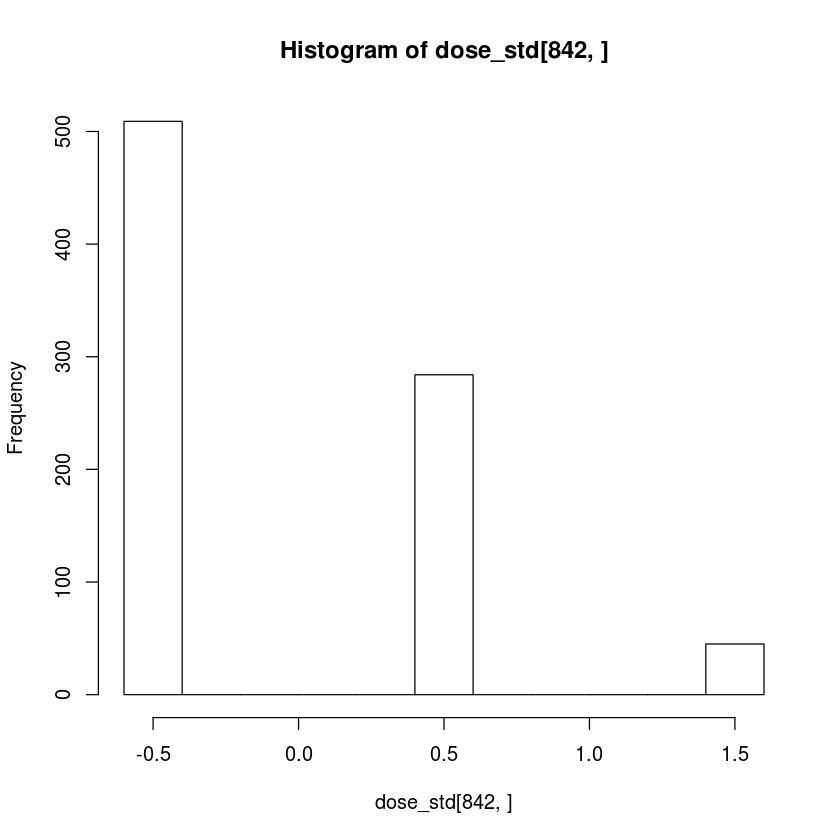

In [41]:
hist(dose_std[842,])

In [33]:
beta_j_lasso_matrix_test[1:6, 1:6]

0.000000000,-0.1574482,-0.03234496,0.005647510,-0.09750642,-0.04202300
0.067264971,0.2310621,0.16041797,0.060012193,-0.04766525,0.21673842
0.000000000,-0.1505302,-0.03169923,0.006085699,-0.09491328,-0.03940134
-0.007833639,-0.6520951,0.15781529,-0.161079257,-0.36514682,0.08808829
0.000000000,-0.1317901,-0.03265220,0.008878893,-0.08237856,-0.03996959
-0.006213497,-0.4796652,0.11696246,-0.116460138,-0.26229224,0.06468829


In [35]:
class(beta_j_lasso_matrix)

[1] "numeric"

In [32]:
sum(beta_j_lasso_matrix)

[1] NaN

In [ ]:
## inner product 

In [56]:
# parameters
lam = 1
X=X_train
Y=Y_train
X1=X_tune
Y1=Y_tune
XX=XX_train
XY=XY
Xnorm=Xnorm
lambda1=lam_V[lam]
lambda2=lam_V[lam]
single_est = matrix(initial_numeric, M, P)
theta=single_est
maxiter = 10

# wrapper function 
dyn.load("/ysm-gpfs/pi/zhao/zy92/projects/utmost_update/CTIMP/optim.so")

bgt = Sys.time()
M = nrow(XY)
P = length(X)
NN = unlist(lapply(X, nrow))
old_objV1 = 0
for(t in 1:P){
    old_objV1 = old_objV1 + 1/2*mean((Y[[t]]-X[[t]]%*%theta[,t])^2)
}
IRdisplay::display_html(paste0("Training error: ", old_objV1, '\n'))
old_objV2 = 0
for(t in 1:P){
    old_objV2 = old_objV2 + 1/2*mean((Y1[[t]]-X1[[t]]%*%theta[,t])^2)
}
IRdisplay::display_html(paste0("Testing error: ", old_objV2, '\n'))
beta_j_lasso = rep(0, P)
beta_j_lasso_matrix = rep(0, M*P)
output_res = rep(0, P)
tmp_XYj = 0

for(i in 1:maxiter){
    bgt = Sys.time()
    res = .Call("wrapper", XX, XY, theta, M, P, beta_j_lasso, beta_j_lasso_matrix, lambda1, lambda2, Xnorm, output_res)
    #IRdisplay::display_html(res)
    edt = Sys.time()
    #print(edt-bgt)
    IRdisplay::display_html(beta_j_lasso)
    #IRdisplay::display_html(theta[1:6, 1:6])
    new_objV1 = new_objV2 = 0
    for(t in 1:P){
        if (theta[])
        new_objV1 = new_objV1 + 1/2*mean((Y[[t]]-X[[t]]%*%theta[,t])^2)
        #IRdisplay::display_html(sum(is.na(X[[t]])))
        #IRdisplay::display_html(sum(is.na(Y[[t]])))
        #IRdisplay::display_html(theta[,t])
    }
    IRdisplay::display_html(paste0("Training error: ", new_objV1, '\n'))
    for(t in 1:P){
        new_objV2 = new_objV2 + 1/2*mean((Y1[[t]]-X1[[t]]%*%theta[,t])^2)
        #IRdisplay::display_html(sum(is.na(X[[t]])))
        #IRdisplay::display_html(sum(is.na(Y[[t]])))
        #IRdisplay::display_html(theta[,t])
    }
    IRdisplay::display_html(paste0("Testing error: ", new_objV2, '\n'))
    if(new_objV2 > old_objV2|new_objV1 > old_objV1){
        break
    }else{
        old_objV2 = new_objV2
    }
    if(abs(new_objV1-old_objV1) < eps){
        break
    }else{
        old_objV1 = new_objV1
    }
}
#edt = Sys.time()
#print(edt-bgt)
#list(est = theta, tune_err = new_objV2)

Training error: 787.928110082842

Testing error: 989.803739515436

Warning message in if (theta[]) new_objV1 = new_objV1 + 1/2 * mean((Y[[t]] - X[[t]] %*% :
“the condition has length > 1 and only the first element will be used”
Warning message in if (theta[]) new_objV1 = new_objV1 + 1/2 * mean((Y[[t]] - X[[t]] %*% :
“the condition has length > 1 and only the first element will be used”
Warning message in if (theta[]) new_objV1 = new_objV1 + 1/2 * mean((Y[[t]] - X[[t]] %*% :
“the condition has length > 1 and only the first element will be used”
Warning message in if (theta[]) new_objV1 = new_objV1 + 1/2 * mean((Y[[t]] - X[[t]] %*% :
“the condition has length > 1 and only the first element will be used”
Warning message in if (theta[]) new_objV1 = new_objV1 + 1/2 * mean((Y[[t]] - X[[t]] %*% :
“the condition has length > 1 and only the first element will be used”
Warning message in if (theta[]) new_objV1 = new_objV1 + 1/2 * mean((Y[[t]] - X[[t]] %*% :
“the condition has length > 1 and only the first element will be used”
Warning message in if (theta[]) ne

Training error: 0

Testing error: NaN

ERROR: Error in if (new_objV2 > old_objV2 | new_objV1 > old_objV1) {: missing value where TRUE/FALSE needed


In [57]:
beta_j_lasso_matrix_test <- matrix(beta_j_lasso_matrix, M, P)

In [58]:
sum(!is.na(beta_j_lasso_matrix))

[1] 41258

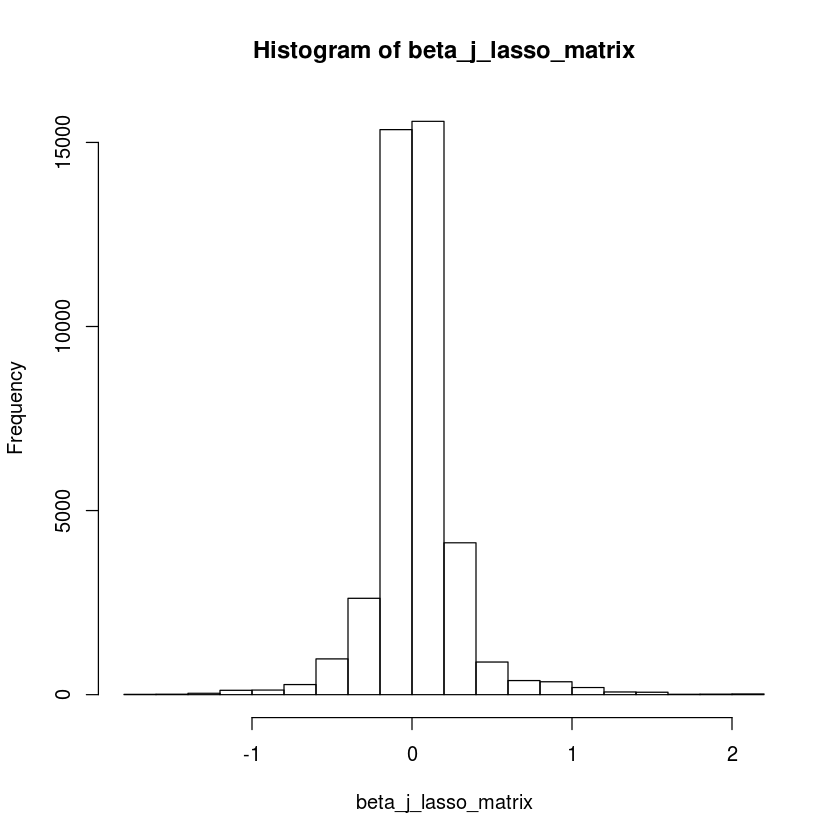

In [59]:
hist(beta_j_lasso_matrix)

In [46]:
head(beta_j_lasso_matrix)

[1]  0.0000000000  0.0000000000 -0.0004795378 -0.0062790769 -0.0006098350
[6] -0.0083802524

In [45]:
sum(is.infinite(beta_j_lasso_matrix))

[1] 48

In [1]:
getwd()

[1] "/gpfs/loomis/pi/zhao2/zy92/projects/utmost_update/utmost_update/code/R"

In [64]:
# parameters
lam = 1
X=X_train
Y=Y_train
X1=X_tune
Y1=Y_tune
XX=XX_train
XY=XY
Xnorm=Xnorm
lambda1=lam_V[lam]
lambda2=lam_V[lam]
single_est = matrix(initial_numeric, M, P)
theta=single_est
maxiter = 10

# wrapper function 
dyn.load("/ysm-gpfs/pi/zhao/zy92/projects/utmost_update/CTIMP/optim.so")

bgt = Sys.time()
M = nrow(XY)
P = length(X)
NN = unlist(lapply(X, nrow))
old_objV1 = 0
for(t in 1:P){
    old_objV1 = old_objV1 + 1/2*mean((Y[[t]]-X[[t]]%*%theta[,t])^2)
}
IRdisplay::display_html(paste0("Training error: ", old_objV1, '\n'))
old_objV2 = 0
for(t in 1:P){
    old_objV2 = old_objV2 + 1/2*mean((Y1[[t]]-X1[[t]]%*%theta[,t])^2)
}
IRdisplay::display_html(paste0("Testing error: ", old_objV2, '\n'))
beta_j_lasso = rep(0, P)
beta_j_lasso_matrix = rep(0, M*P)
output_res = rep(0, P)
tmp_XYj = 0

for(i in 1:maxiter){
    bgt = Sys.time()
    res = .Call("wrapper", XX, XY, theta, M, P, beta_j_lasso, beta_j_lasso_matrix, lambda1, lambda2, Xnorm, output_res)
    #IRdisplay::display_html(res)
    edt = Sys.time()
    #print(edt-bgt)
    IRdisplay::display_html(beta_j_lasso)
    #IRdisplay::display_html(theta[1:6, 1:6])
    new_objV1 = new_objV2 = 0
    for(t in 1:P){
        if (theta[])
        new_objV1 = new_objV1 + 1/2*mean((Y[[t]]-X[[t]]%*%theta[,t])^2)
        #IRdisplay::display_html(sum(is.na(X[[t]])))
        #IRdisplay::display_html(sum(is.na(Y[[t]])))
        #IRdisplay::display_html(theta[,t])
    }
    IRdisplay::display_html(paste0("Training error: ", new_objV1, '\n'))
    for(t in 1:P){
        new_objV2 = new_objV2 + 1/2*mean((Y1[[t]]-X1[[t]]%*%theta[,t])^2)
        #IRdisplay::display_html(sum(is.na(X[[t]])))
        #IRdisplay::display_html(sum(is.na(Y[[t]])))
        #IRdisplay::display_html(theta[,t])
    }
    IRdisplay::display_html(paste0("Testing error: ", new_objV2, '\n'))
    if(new_objV2 > old_objV2|new_objV1 > old_objV1){
        break
    }else{
        old_objV2 = new_objV2
    }
    if(abs(new_objV1-old_objV1) < eps){
        break
    }else{
        old_objV1 = new_objV1
    }
}
#edt = Sys.time()
#print(edt-bgt)
#list(est = theta, tune_err = new_objV2)

Training error: 787.928110082842

Testing error: 989.803739515436

Warning message in if (theta[]) new_objV1 = new_objV1 + 1/2 * mean((Y[[t]] - X[[t]] %*% :
“the condition has length > 1 and only the first element will be used”
Warning message in if (theta[]) new_objV1 = new_objV1 + 1/2 * mean((Y[[t]] - X[[t]] %*% :
“the condition has length > 1 and only the first element will be used”
Warning message in if (theta[]) new_objV1 = new_objV1 + 1/2 * mean((Y[[t]] - X[[t]] %*% :
“the condition has length > 1 and only the first element will be used”
Warning message in if (theta[]) new_objV1 = new_objV1 + 1/2 * mean((Y[[t]] - X[[t]] %*% :
“the condition has length > 1 and only the first element will be used”
Warning message in if (theta[]) new_objV1 = new_objV1 + 1/2 * mean((Y[[t]] - X[[t]] %*% :
“the condition has length > 1 and only the first element will be used”
Warning message in if (theta[]) new_objV1 = new_objV1 + 1/2 * mean((Y[[t]] - X[[t]] %*% :
“the condition has length > 1 and only the first element will be used”
Warning message in if (theta[]) ne

Training error: 0

Testing error: NaN

ERROR: Error in if (new_objV2 > old_objV2 | new_objV1 > old_objV1) {: missing value where TRUE/FALSE needed


In [65]:
beta_j_lasso_matrix_test <- matrix(beta_j_lasso_matrix, M, P)

In [66]:
sum(!is.na(beta_j_lasso_matrix))

[1] 41258

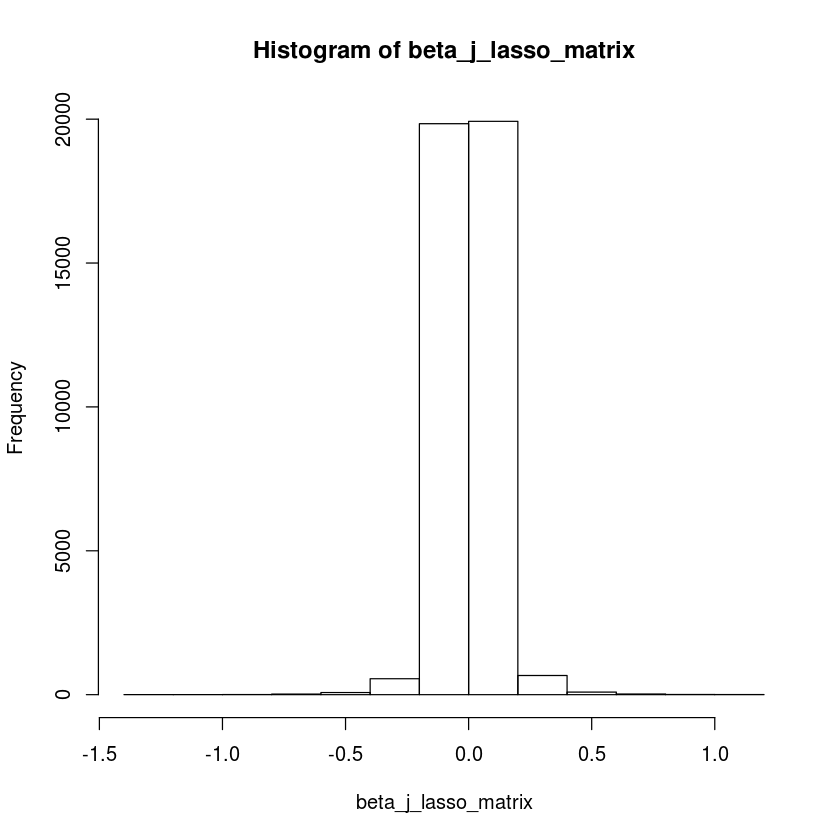

In [67]:
hist(beta_j_lasso_matrix)

In [70]:
class(XX_train)

[1] "list"

In [71]:
XX_train[[1]]

,chr2_71129368_C_T_b38,chr2_71129592_A_T_b38,chr2_71130065_C_A_b38,chr2_71130287_C_A_b38,chr2_71130375_C_T_b38,chr2_71130504_C_T_b38,chr2_71130580_G_C_b38,chr2_71130634_A_G_b38,chr2_71130975_A_G_b38,chr2_71131072_T_C_b38,⋯,chr2_73146320_G_A_b38,chr2_73146576_C_G_b38,chr2_73146922_A_G_b38,chr2_73146968_T_C_b38,chr2_73146997_T_C_b38,chr2_73147028_G_A_b38,chr2_73147287_T_C_b38,chr2_73147326_A_G_b38,chr2_73147380_G_C_b38,chr2_73147737_A_T_b38
chr2_71129368_C_T_b38,0.0385416845,-0.009852114,0.0385416845,0.034113599,0.0385416845,0.034121369,-0.017467388,-0.0005514403,0.0385416845,0.0385416845,⋯,0.025158622,0.0011838990,0.0152904568,0.0152904568,-0.002262297,0.0152904568,-0.002262297,0.0152904568,8.552233e-03,0.025026589
chr2_71129592_A_T_b38,-0.0098521137,0.253474776,-0.0098521137,-0.129003757,-0.0098521137,-0.129118726,0.207716501,-0.0053505669,-0.0098521137,-0.0098521137,⋯,-0.038582881,-0.0100653399,-0.0183421277,-0.0183421277,-0.004714161,-0.0183421277,-0.004714161,-0.0183421277,-1.159928e-02,-0.040006750
chr2_71130065_C_A_b38,0.0385416845,-0.009852114,0.0385416845,0.034113599,0.0385416845,0.034121369,-0.017467388,-0.0005514403,0.0385416845,0.0385416845,⋯,0.025158622,0.0011838990,0.0152904568,0.0152904568,-0.002262297,0.0152904568,-0.002262297,0.0152904568,8.552233e-03,0.025026589
chr2_71130287_C_A_b38,0.0341135989,-0.129003757,0.0341135989,0.548562093,0.0341135989,0.548651806,-0.208811262,0.0173959129,0.0341135989,0.0341135989,⋯,0.157888691,0.0064917207,0.1067866949,0.1067866949,-0.018760236,0.1067866949,-0.018760236,0.1067866949,4.135110e-02,0.154629515
chr2_71130375_C_T_b38,0.0385416845,-0.009852114,0.0385416845,0.034113599,0.0385416845,0.034121369,-0.017467388,-0.0005514403,0.0385416845,0.0385416845,⋯,0.025158622,0.0011838990,0.0152904568,0.0152904568,-0.002262297,0.0152904568,-0.002262297,0.0152904568,8.552233e-03,0.025026589
chr2_71130504_C_T_b38,0.0341213685,-0.129118726,0.0341213685,0.548651806,0.0341213685,0.548747214,-0.208980844,0.0173865194,0.0341213685,0.0341213685,⋯,0.158027544,0.0065558010,0.1068834274,0.1068834274,-0.018698229,0.1068834274,-0.018698229,0.1068834274,4.133106e-02,0.154770292
chr2_71130580_G_C_b38,-0.0174673880,0.207716501,-0.0174673880,-0.208811262,-0.0174673880,-0.208980844,0.382857330,0.0079743363,-0.0174673880,-0.0174673880,⋯,-0.055072676,-0.0238376185,-0.0251944718,-0.0251944718,-0.024083672,-0.0251944718,-0.024083672,-0.0251944718,-8.560153e-03,-0.057592243
chr2_71130634_A_G_b38,-0.0005514403,-0.005350567,-0.0005514403,0.017395913,-0.0005514403,0.017386519,0.007974336,0.0172515636,-0.0005514403,-0.0005514403,⋯,0.012159441,0.0042802886,0.0059962164,0.0059962164,-0.003949594,0.0059962164,-0.003949594,0.0059962164,1.802817e-03,0.012079322
chr2_71130975_A_G_b38,0.0385416845,-0.009852114,0.0385416845,0.034113599,0.0385416845,0.034121369,-0.017467388,-0.0005514403,0.0385416845,0.0385416845,⋯,0.025158622,0.0011838990,0.0152904568,0.0152904568,-0.002262297,0.0152904568,-0.002262297,0.0152904568,8.552233e-03,0.025026589
chr2_71131072_T_C_b38,0.0385416845,-0.009852114,0.0385416845,0.034113599,0.0385416845,0.034121369,-0.017467388,-0.0005514403,0.0385416845,0.0385416845,⋯,0.025158622,0.0011838990,0.0152904568,0.0152904568,-0.002262297,0.0152904568,-0.002262297,0.0152904568,8.552233e-03,0.025026589


In [ ]:
class(beta_j_lasso[[1]])

In [ ]:
beta_j_lasso

In [ ]:
output_res

In [ ]:
beta_j_lasso[[2]]

In [59]:
dim(theta)

[1] 6092   49

In [62]:
sum(theta == single_est)

[1] 298508

In [55]:
dim(single_est)

[1] 6092   49

In [ ]:
single_est[c()]

In [ ]:
sum(is.na(dose_std))

In [ ]:
hist(dose_std)

In [ ]:
which(is.na(single_est))

In [ ]:
which(is.na(initial_numeric))

In [ ]:
head(initial_numeric)
single_est[1, 1:6]

In [ ]:
single_est = matrix(initial_numeric, M, P)

In [ ]:
head(single_est)

In [ ]:
head(single_est)

In [ ]:
class(Y_train[[1]])

In [ ]:
hist(Y_train[[2]])

In [ ]:
for(lam in 1:ntune){
        single_est = matrix(initial_numeric, M, P)
        ans = glasso(X=X_train, Y=Y_train, X1=X_tune, Y1=Y_tune, XX=XX_train, XY=XY, Xnorm=Xnorm, lambda1=lam_V[lam], lambda2=lam_V[lam], theta=single_est)
        res_tune[lam] = ans$tune_err
        remove(single_est); remove(ans);
}

In [24]:
dim(single_est)

[1] 6092   49

In [25]:
sum(is.na(single_est))

[1] 47

In [26]:
res_na <- apply(single_est, 1, function(x) sum(is.na(x)))

In [27]:
res_inf <- apply(single_est, 1, function(x) sum(!is.finite(x)))

In [28]:
which(res_na != 0)

[1] 851

In [29]:
which(res_inf != 0)

[1]  839  840  841  842  843  844  845  847  848  849  851  855  939  975 1291
[16] 1433 1444 1496 1807 1872 2201 2284 2369 2415 2443 3956

In [30]:
single_est[which(res_inf != 0), ]

0,-Inf,Inf,Inf,Inf,-Inf,0,0,0,Inf,⋯,0,-Inf,Inf,0,-Inf,0,Inf,Inf,Inf,0
Inf,Inf,-Inf,-Inf,-Inf,Inf,Inf,0,-Inf,-Inf,⋯,0,Inf,Inf,Inf,-Inf,0,-Inf,-Inf,-Inf,-Inf
Inf,0,0,0,0,0,Inf,Inf,-Inf,-Inf,⋯,0,0,Inf,Inf,-Inf,Inf,0,0,0,-Inf
0,0,0,0,0,0,0,-Inf,0,0,⋯,0,0,0,0,0,-Inf,0,0,0,0
Inf,0,0,0,0,0,Inf,0,-Inf,0,⋯,Inf,0,Inf,Inf,-Inf,0,0,0,0,-Inf
0,0,0,0,0,0,0,0,0,0,⋯,Inf,0,0,0,0,0,0,0,Inf,0
0,0,0,0,0,0,0,0,0,0,⋯,Inf,0,0,0,0,0,0,0,0,0
Inf,0,0,0,0,0,0,0,0,0,⋯,0,0,0,Inf,-Inf,0,0,Inf,Inf,-Inf
-Inf,-Inf,Inf,0,Inf,-Inf,-Inf,0,Inf,0,⋯,-Inf,-Inf,0,-Inf,0,0,Inf,0,0,Inf
0,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,⋯,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
dim(X_train[[1]])
sum(is.na(X_train[[1]]))

In [ ]:
res_l <- lapply(X_train, function(x) sum(is.na(x)))

In [ ]:
res_l

In [ ]:
hist(X_train[[1]])

In [ ]:
dim(XY)
class(XY)

In [ ]:
sum(is.na(XY))

[1] 0

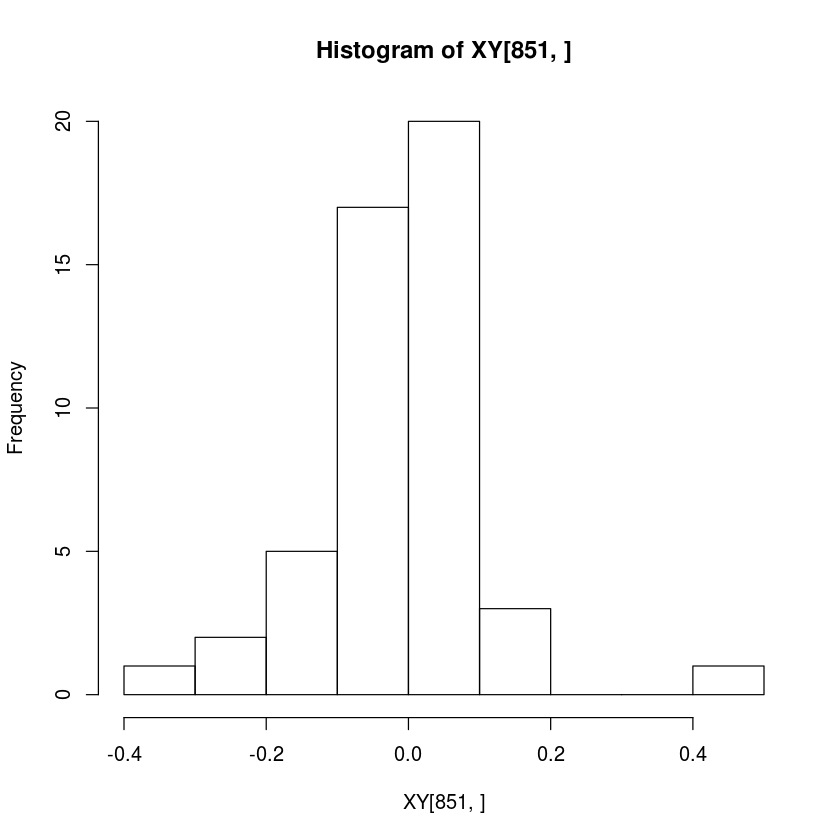

In [48]:
hist(XY[851, ])
sum(is.na(XY[851, ]))

[1] 0

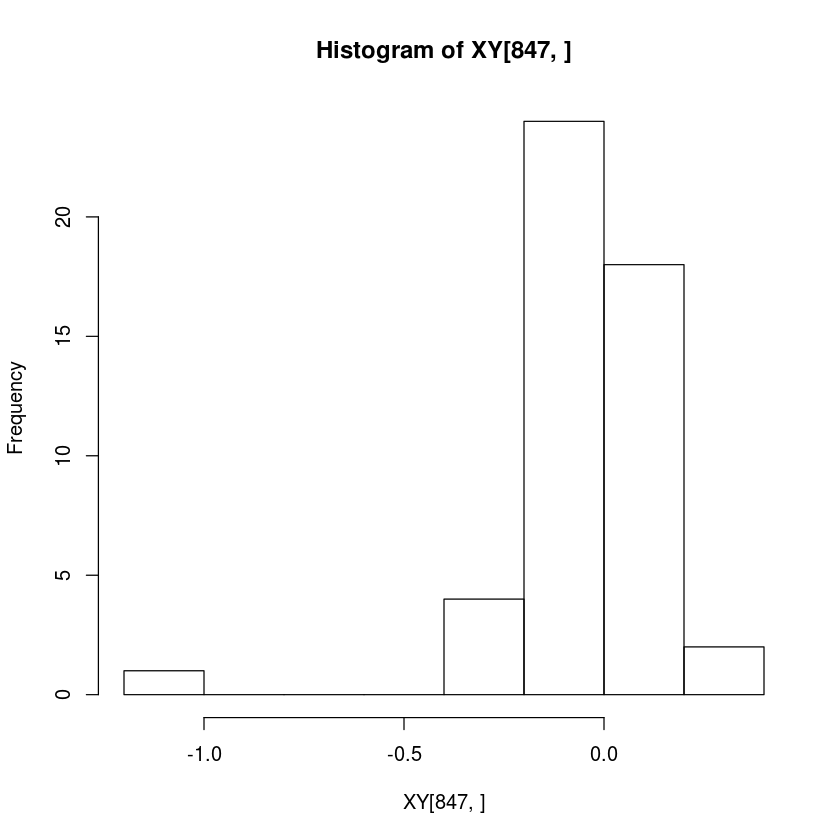

In [47]:
hist(XY[847, ])
sum(is.na(XY[847, ]))

In [46]:
dim(XY)

[1] 6092   49

[1] 0

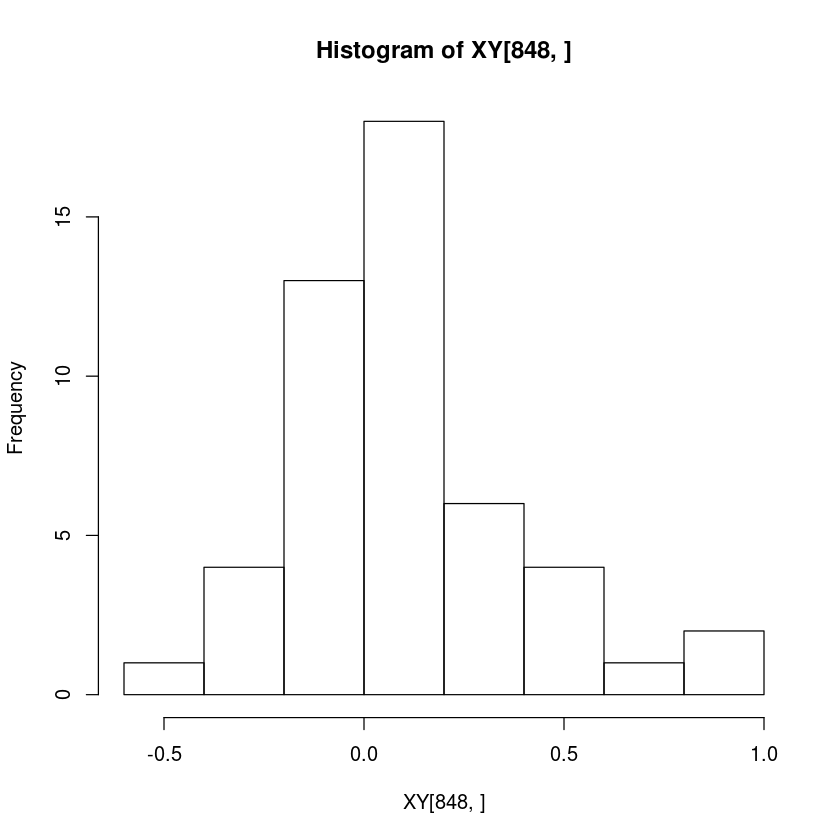

In [42]:
hist(XY[848, ])
sum(is.na(XY[848, ]))

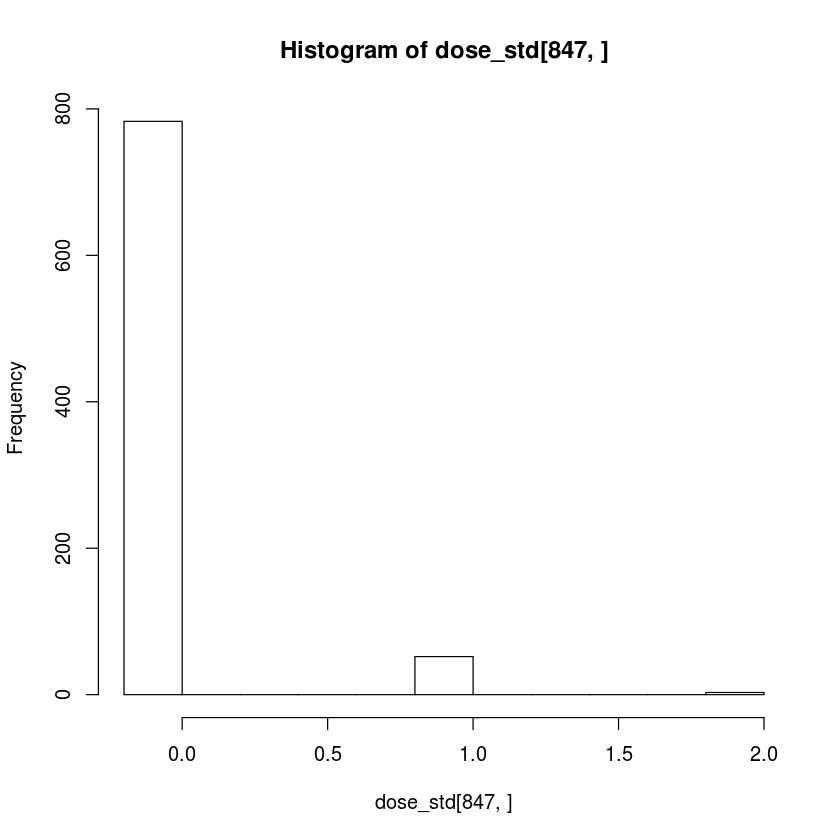

In [43]:
hist(dose_std[847, ])

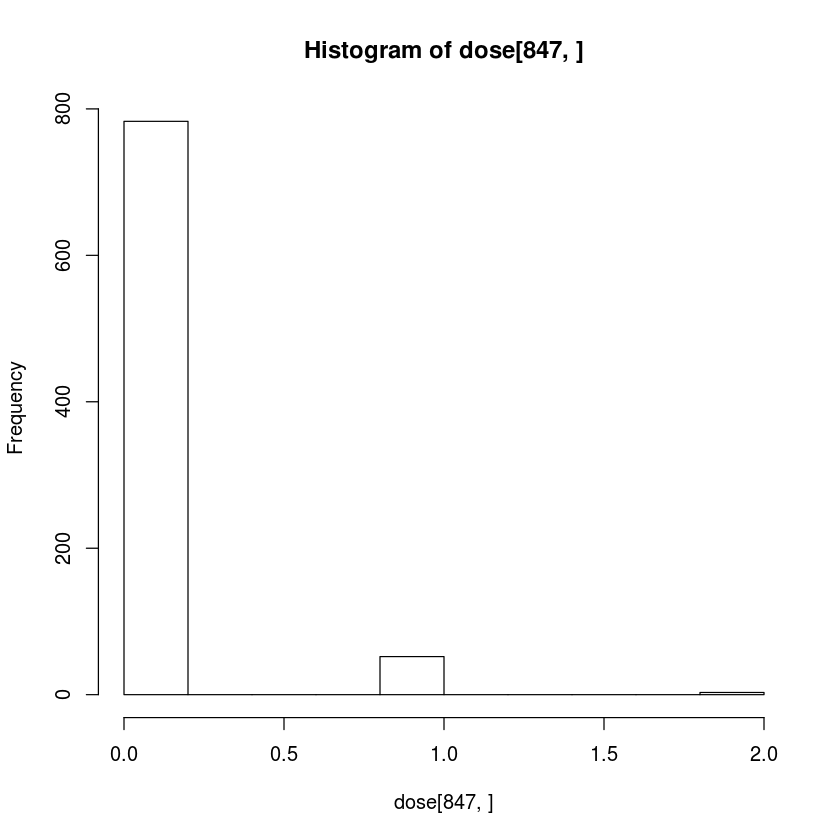

In [44]:
hist(dose[847, ])

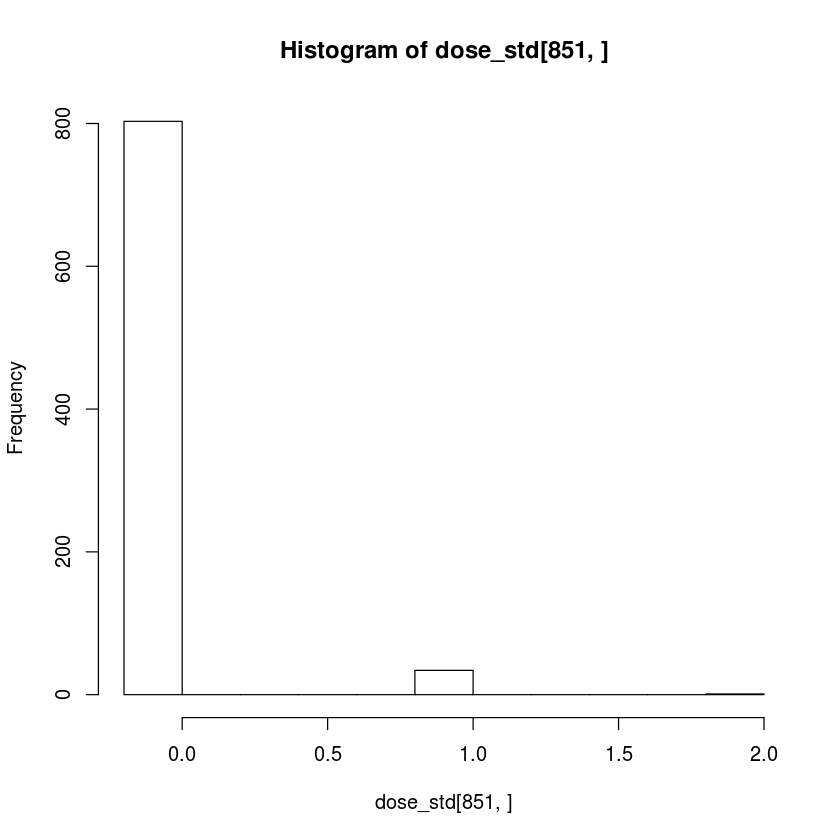

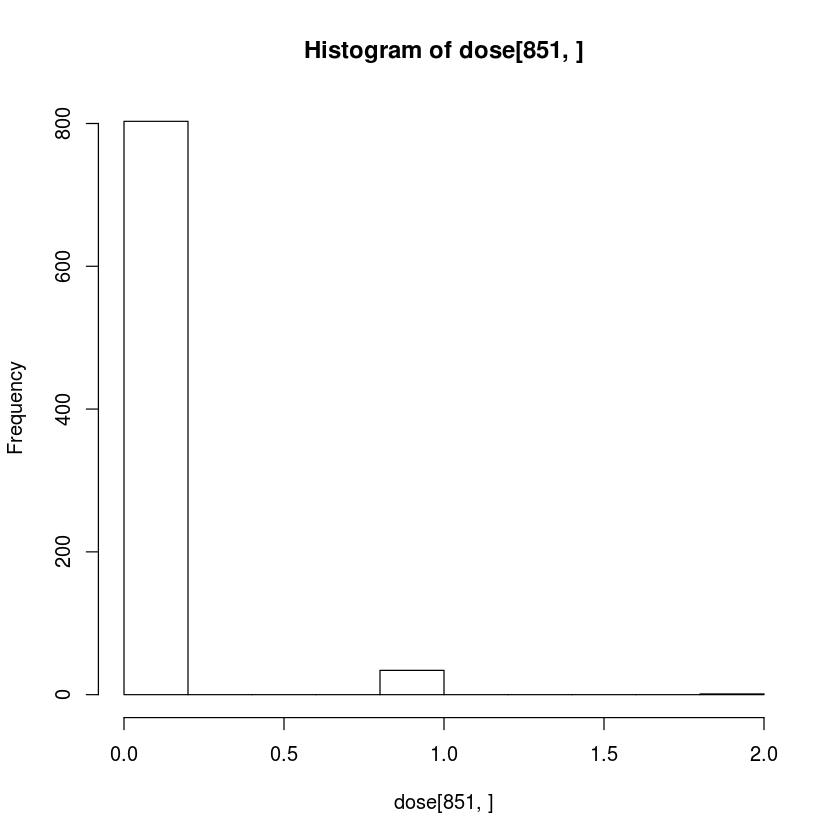

In [49]:
hist(dose_std[851, ])
hist(dose[851, ])

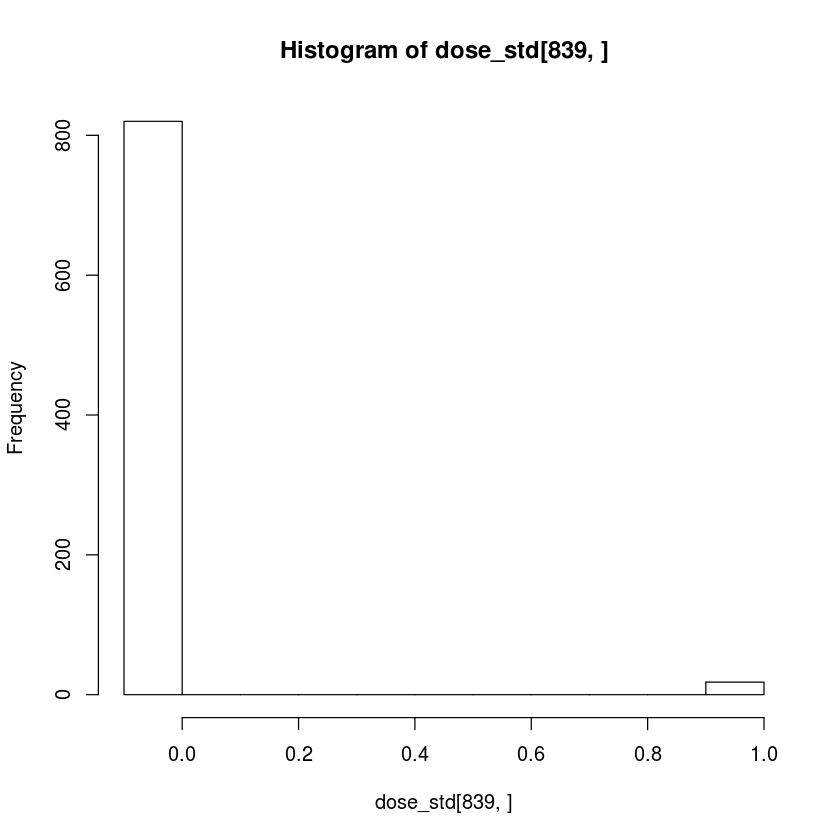

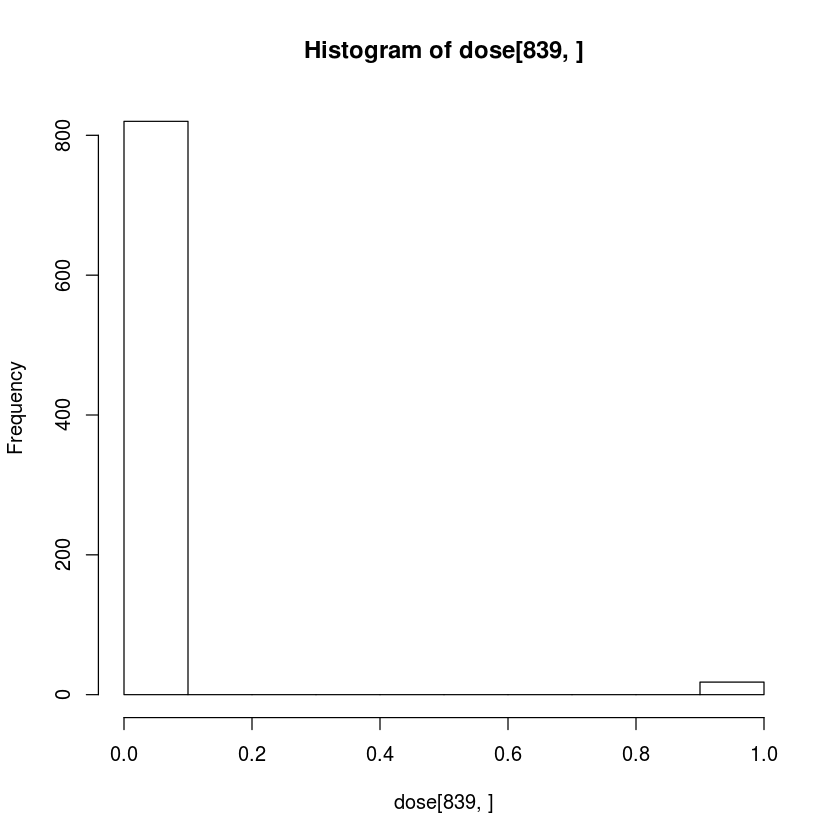

In [50]:
hist(dose_std[839, ])
hist(dose[839, ])

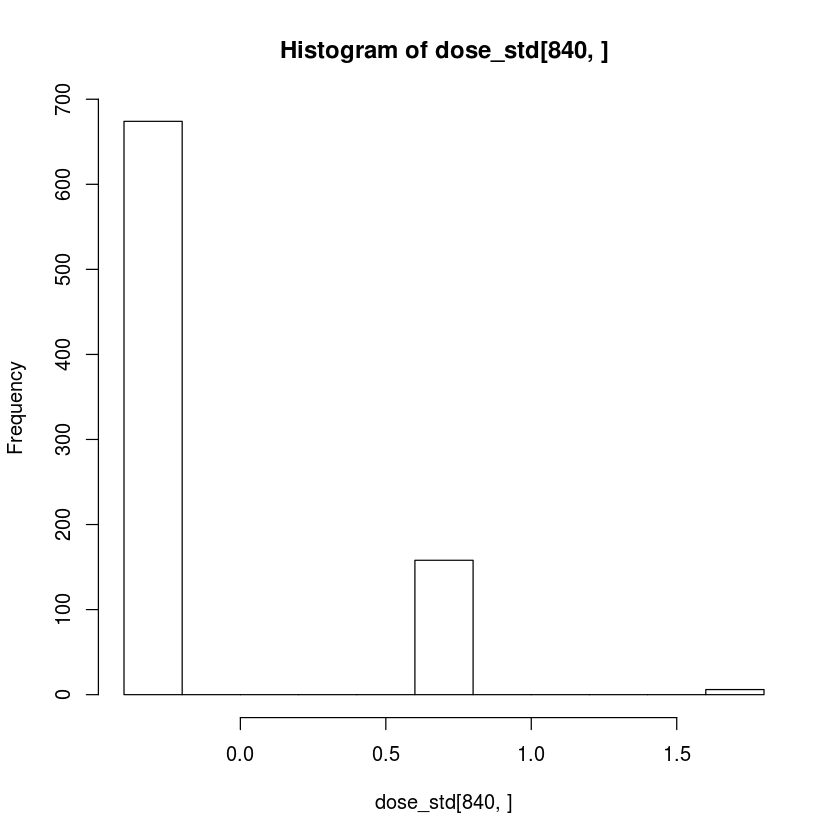

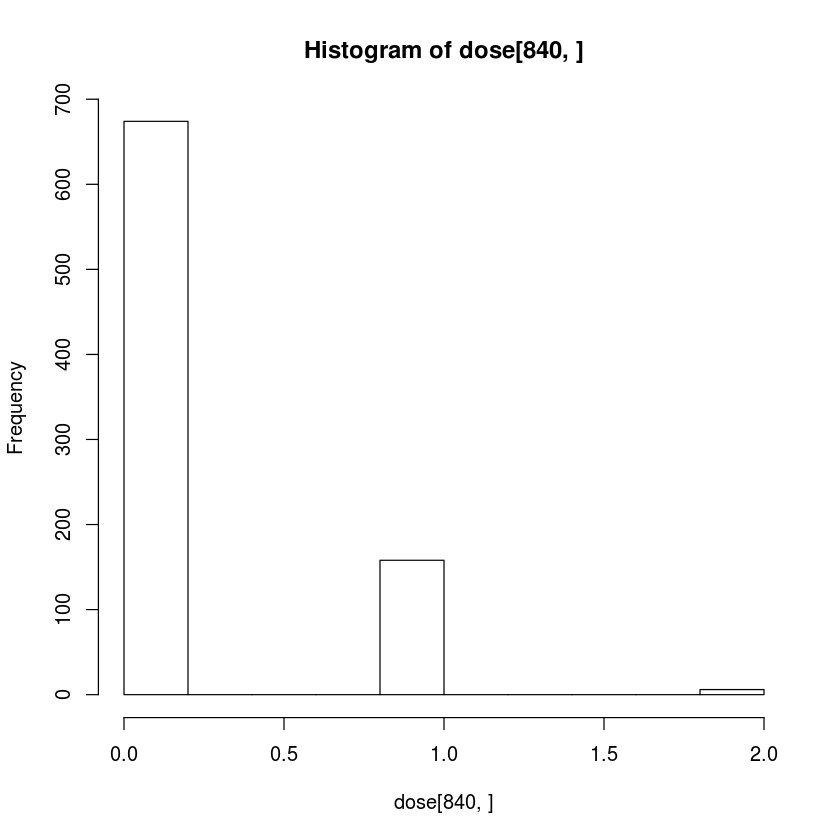

In [51]:
hist(dose_std[840, ])
hist(dose[840, ])

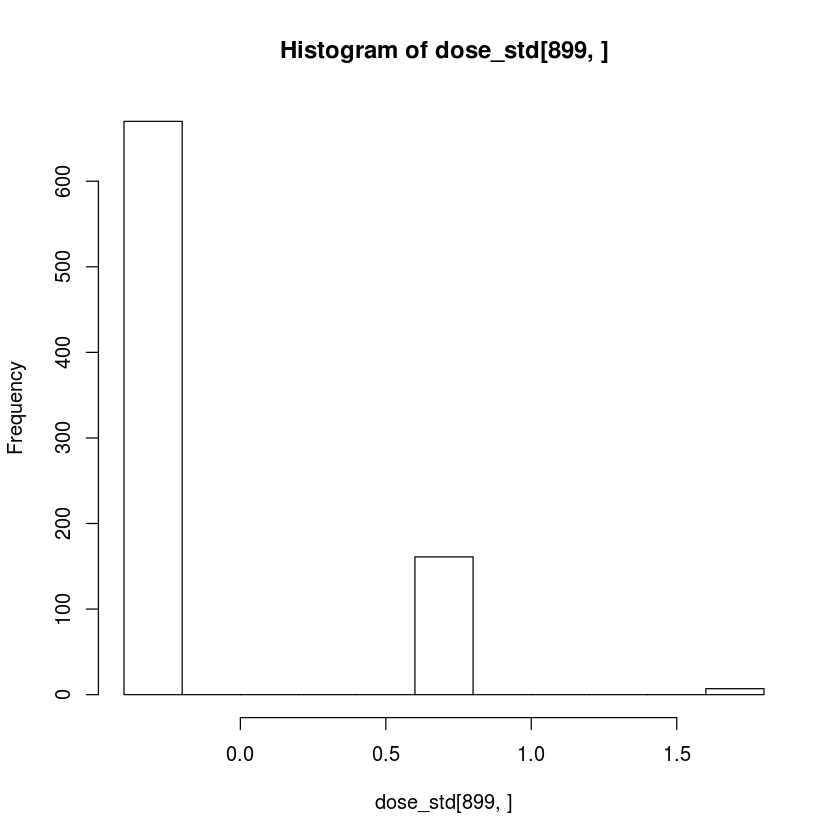

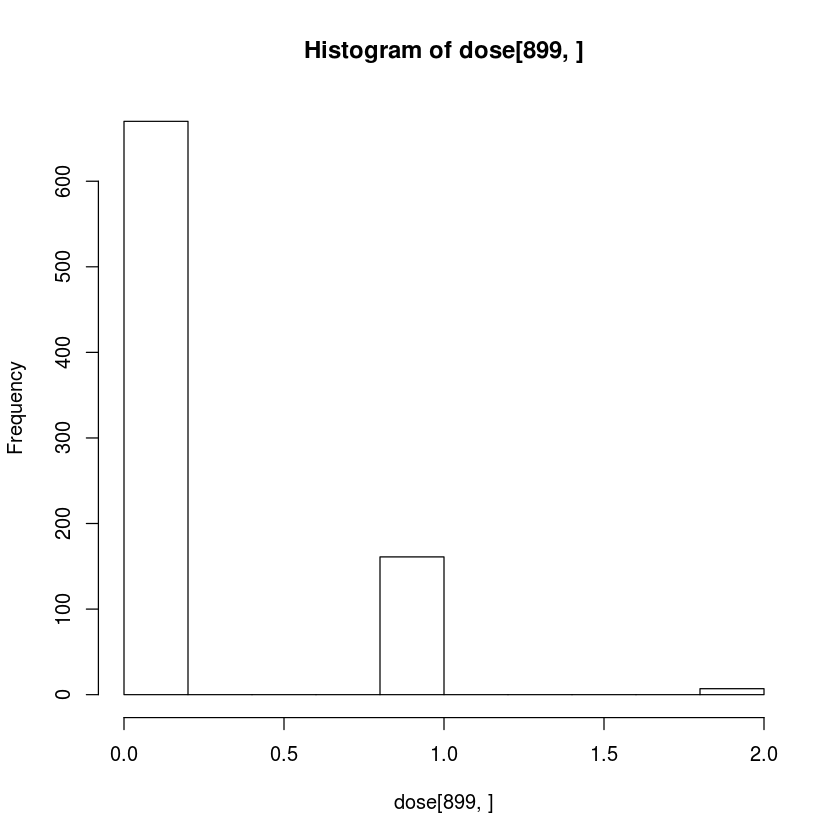

In [52]:
hist(dose_std[899, ])
hist(dose[899, ])

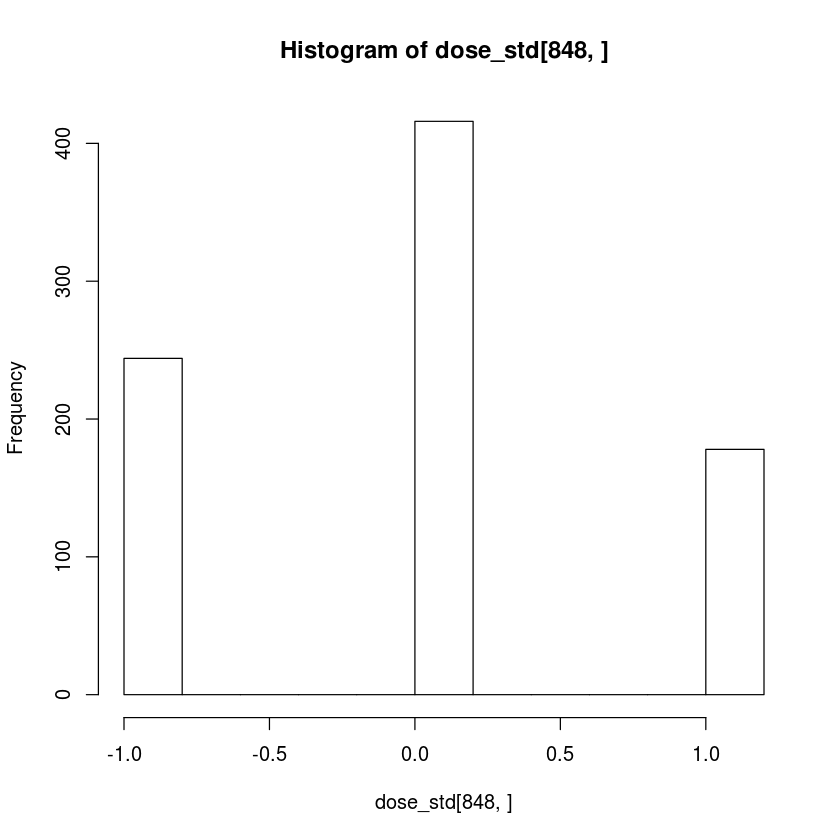

In [45]:
hist(dose_std[848, ])

In [ ]:
dim(XX_train[[1]])

In [ ]:
hist(XX_train[[1]][848, ])

In [ ]:
length(dose_std[, 848])

In [ ]:
dim(dose_std)

In [ ]:
hist(dose_std[848, ])

In [ ]:
dim(single_est[,idx])
dim(dose_std[,idx])

In [ ]:
idx = res_na[1]
t(single_est[, idx]) %*% dose_std[, idx]

In [ ]:
XX_train[[1]][848, ] %*% single_est[848, ]

In [ ]:
head(single_est)

In [ ]:
dim(beta_j_lasso[[1]])

In [ ]:
#gene_id = gene_vec
#if(P){
	
	
	## genotype files ##
	#dose = read.table(dose_path, header=F)
    genotype_info <- read_plink(dose_path)
    dose = genotype_info$X
    dose_std = dose
	for(j in 1:nrow(dose)){
		dose_std[j, is.na(dose[j, ])] <- mean(dose[j, ], na.rm = T)
        dose_std[j, ] <- dose_std[j, ] - mean(dose[j, ], na.rm = T)
	}
	print("INFO: section A")
	## covariance matrix ##
    n_sample = ncol(dose_std)
	tmp = as.matrix(dose_std)
	XX = t(tmp)%*%as.matrix(tmp)/n_sample
	Xnorm = diag(XX)
	remove(tmp)
    remove(XX)
	sub_id = colnames(dose_std)
	M = nrow(dose_std)
	sub_id_map = list()
    sub_id_map_exp = list()
	for(t in 1:T_num){
    #for(t in 1:1){
		#tmp = rep(0, nrow(Y[[t]]))
        exp_id <- as.character(sapply(Y[[t]][,1], function(x) substr(x, 1, 10)))
        #print(head(exp_id))
        # index of ids that have matched genotypes 
        # exp_id based on order of exp_id
        match_id <- match(exp_id, sub_id)
		sub_id_map[[t]] <- na.omit(match_id)
        sub_id_map_exp[[t]] <- !is.na(match_id)                           
        #for(j in 1:length(tmp)){
            # extract the id starting GTEX-xxxxx
            
			#tmp[j] = which(sub_id==exp_id)
		#}
		#sub_id_map[[t]] = tmp
	}
	
	fold = 5
	print("INFO: section B")
	cv_config = cv_helper(n_sample, fold)
	cv_perm = cv_config$perm
	cv_idx = cv_config$idx
	
	single_res_test = list()
	single_lam = matrix(0,5,P)
	single_theta_est = list()
	
	multi_res_test = list()
	multi_lam = rep(0,5)
	multi_theta_est = list()
	
	for(f in 1:fold){
        # one fold 
		bgt = Sys.time()
        print(paste0("INFO: fold ", f))
		test_index = cv_perm[cv_idx[f,1]:cv_idx[f,2]]
		test_id = sub_id[test_index]
        
        # move the tuning idx to another idx block
		tuning_index = cv_perm[cv_idx[f%%fold+1,1]:cv_idx[f%%fold+1,2]]
		tuning_id = sub_id[tuning_index]
        
        # idx list
		X_test = list()
		Y_test = list()
		X_tune = list()
		Y_tune = list()
		X_train = list()
		Y_train = list()
		for(t in 1:T_num){
            # idx matching  
            id_filter = !(sub_id_map[[t]]%in%c(test_index,tuning_index))
            X_train_tmp = sub_id_map[[t]][id_filter]
			Y_train_tmp = sub_id_map_exp[[t]][id_filter]
            tuning_id_filter = sub_id_map[[t]]%in%tuning_index
			X_tuning_tmp = sub_id_map[[t]][tuning_id_filter]
			Y_tuning_tmp = sub_id_map_exp[[t]][tuning_id_filter]
            testing_id_filter = sub_id_map[[t]]%in%testing_index
			X_test_tmp = sub_id_map[[t]][testing_id_filter]
			Y_test_tmp = sub_id_map_exp[[t]][testing_id_filter]
            # training data
			X_train[[t]] = apply(as.matrix(dose_std[,X_train_tmp]),1,as.numeric)
			Y_train[[t]] = Y[[t]]][Y_train_tmp, 2]
			X_tune[[t]] = apply(as.matrix(dose_std[,X_tuning_tmp]),1,as.numeric)
			Y_tune[[t]] = Y[[t]][Y_tuning_tmp, 2]
			X_test[[t]] = apply(as.matrix(dose_std[,X_test_tmp]),1,as.numeric)
			Y_test[[t]] = Y[[t]][Y_test_tmp, 2]
		}
		
		## model training ##	
		## train elastic net and used average lambda as tuning parameters ##
		single_initial_est = matrix(0, ncol(X_train[[1]]), T_num)
		single_summary = list()
		for(t in 1:T_num){
            #print(Y_train[[t]])
            #print(sum(is.na(X_train[[t]])))
			tt = cv.glmnet(X_train[[t]], Y_train[[t]], alpha = 0.5, nfolds = 5)
			single_summary[[t]] = tt
			single_initial_est[,t] = tt$glmnet.fit$beta[,which.min(tt$cvm)]
		}
		## performance of Elastic net on tuning and testing data with various tuning parameters
		els_output = elastic_net_mse(single_summary, X_tune, Y_tune, X_test, Y_test)
		single_res_test[[f]] = els_output$mse
		single_lam[f,] = els_output$lam
		single_theta_est[[f]] = els_output$est
		remove(els_output)
		
		initial_numeric = as.numeric(single_initial_est)
		lam_range = minmax_lambda(single_summary)
		lam_V = seq(lam_range[1], lam_range[2], length.out = ntune)
		remove(single_summary); 
        remove(single_initial_est);
	
		## preparation
		XY = grad_prep(X_train, Y_train)
#		bgt = Sys.time()
		XX_train = lapply(X_train, function(x){t(x)%*%x/nrow(x)})
#		edt = Sys.time()
#		print(edt-bgt)
	
		
		res_tune = rep(0, ntune)
		best.lam = 0
	
#		bgt = Sys.time()
		for(lam in 1:ntune){
			single_est = matrix(initial_numeric, M, P)
			ans = glasso(X=X_train, Y=Y_train, X1=X_tune, Y1=Y_tune, XX=XX_train, XY=XY, Xnorm=Xnorm, lambda1=lam_V[lam], lambda2=lam_V[lam], theta=single_est)
			res_tune[lam] = ans$tune_err
			remove(single_est); remove(ans);
		}
#		edt = Sys.time()
#		print(edt-bgt)

		best.lam = lam_V[which.min(res_tune)]
		single_est = matrix(initial_numeric, M, P)
		ans = glasso(X=X_train, Y=Y_train, X1=X_tune, Y1=Y_tune, XX=XX_train, XY=XY, Xnorm=Xnorm, lambda1=best.lam, lambda2=best.lam, theta=single_est)
		multi_res_test[[f]] = multi_mse(ans$est, X_test, Y_test)
		multi_lam[f] = best.lam
		multi_theta_est[[f]] = ans$est
		remove(single_est)
        remove(ans)
		edt = Sys.time()
		print(edt-bgt)
	}
    print("INFO: section C")
	save(single_res_test, single_lam, single_theta_est, multi_res_test, multi_lam, multi_theta_est, file = paste0('chr', chr, '.', k, '.', gene_id, ".RData"))
	
    # evaluation                                  
    res_single = avg_perm(single_res_test)
	res_multi = avg_perm(multi_res_test)
	cat("Elastic net average testing error (all): ", apply(res_single, 2, mean), '\n')
    cat("glasso averge testing error (all): ", apply(res_multi, 2, mean), '\n')
	cat("Number of all zero tissues in elastic net is ", sum(is.na(res_single[,1])), '\n')
	cat("Number of all zero tissues in glasso is ", sum(is.na(res_multi[,1])), '\n')
	#cat("Elastic net average testing error (non-zero): ", apply(res_single[!is.na(res_multi[,1]),], 2, mean), '\n')
	#cat("glasso averge testing error (non-zero): ", apply(res_multi[!is.na(res_multi[,1]),], 2, mean), '\n')

	## generate an estimate with whole data ##
	X_all = list()
	Y_all = list()
	for(t in 1:T_num){
		X_all_tmp = sub_id_map[[t]]
		X_all[[t]] = apply(as.matrix(dose[X_all_tmp, ]), 2, as.numeric)
		Y_all[[t]] = Y[[t]][,2]
	}
	# initial values 
	single_initial_est = matrix(0, ncol(X_train[[1]]), T_num)
	for(t in 1:T_num){
		tt = cv.glmnet(X_all[[t]], Y_all[[t]], alpha = 0.5, nfolds = 5)
		single_initial_est[,t] = tt$glmnet.fit$beta[,which.min(tt$cvm)]
	}
	initial_numeric = as.numeric(single_initial_est)
	remove(single_initial_est)
	XY = grad_prep(X_all, Y_all)
	XX_all = lapply(X_all, function(x){t(x)%*%x/nrow(x)})
	tmp_res = rep(0, fold)
	for(f in 1:fold){
		ans = glasso_no_early_stopping(X=X_all, Y=Y_all, XX=XX_all, XY=XY, Xnorm=Xnorm, lambda1=multi_lam[f], lambda2=multi_lam[f], theta=matrix(initial_numeric,M,P))
		tmp_res[f] = ans$train_err
	}
	ans = glasso_no_early_stopping(X=X_all, Y=Y_all, XX=XX_all, XY=XY, Xnorm=Xnorm, lambda1=multi_lam[which.min(tmp_res)], lambda2=multi_lam[which.min(tmp_res)], theta=matrix(initial_numeric,M,P))
	# id ref alt
    info = genotype$bim[, c(2,5,6)] 
	downstream_est = data.frame(info[,1:3], ans$est)
    
	write.table(downstream_est, paste0(gene_id, ".est"), quote=F, row.names=F, col.names=c("SNP", "REF.0.", "ALT.1.", Yt))
#}

### Preparation

In [ ]:
# prepa
dir.create(paste0(output_dir, "chr", chr), showWarnings = FALSE)
dir.create(paste0(output_dir, "chr", chr, "/", gene_id), showWarnings = FALSE)
setwd(paste0(output_dir, "chr", chr, "/", gene_id))
## expr files ##
Y = list()
for(t in 1:P){
    Y[[t]] = read.table(paste0(gtex_dir, "adjusted_expr1/chr", chr, "/", g, "/", Yt[t]), header=F)
}
ssize = unlist(lapply(Y, nrow))
T_num = length(Yt)

## genotype files ##
#dose = read.table(dose_path, header=F)
genotype_info <- read_plink(dose_path)
dose = genotype_info$X
dose_std = dose
for(j in 1:nrow(dose)){
    dose_std[j, is.na(dose[j, ])] <- mean(dose[j, ], na.rm = T)
    dose_std[j, ] <- dose_std[j, ] - mean(dose[j, ], na.rm = T)
}
print("INFO: section A")
## covariance matrix ##
n_sample = ncol(dose_std)
tmp = as.matrix(dose_std)
XX = t(tmp)%*%as.matrix(tmp)/n_sample
Xnorm = diag(XX)
remove(tmp)
remove(XX)
sub_id = colnames(dose_std)
M = nrow(dose_std)
sub_id_map = list()
sub_id_map_genotype = list()
for(t in 1:T_num){
#for(t in 1:1){
    #tmp = rep(0, nrow(Y[[t]]))
    exp_id <- as.character(sapply(Y[[t]][,1], function(x) substr(x, 1, 10)))
    #print(head(exp_id))
    # index of ids that have matched genotypes 
    # exp_id based on order of exp_id
    sub_id_map[[t]] <- na.omit(match(exp_id, sub_id))
    sub_id_map_genotype[[t]] <- !is.na(match(exp_id, sub_id))                           
    #for(j in 1:length(tmp)){
        # extract the id starting GTEX-xxxxx

        #tmp[j] = which(sub_id==exp_id)
    #}
    #sub_id_map[[t]] = tmp
}

fold = 5
print("INFO: section B")
cv_config = cv_helper(n_sample, fold)
cv_perm = cv_config$perm
cv_idx = cv_config$idx

single_res_test = list()
single_lam = matrix(0,5,P)
single_theta_est = list()

multi_res_test = list()
multi_lam = rep(0,5)
multi_theta_est = list()

### CV

In [ ]:
### fold = 1
    f = 1
    bgt = Sys.time()
    IRdisplay::display_html(paste0("INFO: fold ", f))
    test_index = cv_perm[cv_idx[f,1]:cv_idx[f,2]]
    test_id = sub_id[test_index]
    tuning_index = cv_perm[cv_idx[f%%fold+1,1]:cv_idx[f%%fold+1,2]]
    tuning_id = sub_id[tuning_index]

    X_test = list()
    Y_test = list()
    X_tune = list()
    Y_tune = list()
    X_train = list()
    Y_train = list()
    for(t in 1:T_num){
        X_train_tmp = sub_id_map[[t]][!(sub_id_map[[t]]%in%c(test_index,tuning_index))]
        Y_train_tmp = !(sub_id_map[[t]]%in%c(test_index,tuning_index))
        X_tuning_tmp = sub_id_map[[t]][(sub_id_map[[t]]%in%tuning_index)]
        Y_tuning_tmp = (sub_id_map[[t]]%in%tuning_index)
        X_test_tmp = sub_id_map[[t]][(sub_id_map[[t]]%in%test_index)]
        Y_test_tmp = (sub_id_map[[t]]%in%test_index)
        # training data
        X_train[[t]] = apply(as.matrix(dose_std[,X_train_tmp]),1,as.numeric)
        Y_train[[t]] = Y[[t]][sub_id_map_genotype[[t]],][Y_train_tmp, 2]
        X_tune[[t]] = apply(as.matrix(dose_std[,X_tuning_tmp]),1,as.numeric)
        Y_tune[[t]] = Y[[t]][sub_id_map_genotype[[t]],][Y_tuning_tmp, 2]
        X_test[[t]] = apply(as.matrix(dose_std[,X_test_tmp]),1,as.numeric)
        Y_test[[t]] = Y[[t]][sub_id_map_genotype[[t]],][Y_test_tmp, 2]
    }

    ## model training ##	
    ## train elastic net and used average lambda as tuning parameters ##
    single_initial_est = matrix(0, ncol(X_train[[1]]), T_num)
    single_summary = list()
    for(t in 1:T_num){
        IRdisplay::display_html(length(Y_train[[t]]))
        IRdisplay::display_html(dim(X_train[[t]]))
        tt = cv.glmnet(X_train[[t]], Y_train[[t]], alpha = 0.5, nfolds = 5)
        single_summary[[t]] = tt
        single_initial_est[,t] = tt$glmnet.fit$beta[,which.min(tt$cvm)]
    }
    ## performance of Elastic net on tuning and testing data with various tuning parameters
    els_output = elastic_net_mse(single_summary, X_tune, Y_tune, X_test, Y_test)
    single_res_test[[f]] = els_output$mse
    single_lam[f,] = els_output$lam
    single_theta_est[[f]] = els_output$est
    remove(els_output)

    initial_numeric = as.numeric(single_initial_est)
    lam_range = minmax_lambda(single_summary)
    lam_V = seq(lam_range[1], lam_range[2], length.out = ntune)
    remove(single_summary); 
    remove(single_initial_est);

    ## preparation
    XY = grad_prep(X_train, Y_train)
#		bgt = Sys.time()
    XX_train = lapply(X_train, function(x){t(x)%*%x/nrow(x)})
#		edt = Sys.time()
#		print(edt-bgt)


    res_tune = rep(0, ntune)
    best.lam = 0

#		bgt = Sys.time()
    print("INFO: section C")
    for(lam in 1:ntune){
        single_est = matrix(initial_numeric, M, P)
        ans = glasso(X=X_train, Y=Y_train, X1=X_tune, Y1=Y_tune, XX=XX_train, XY=XY, Xnorm=Xnorm, lambda1=lam_V[lam], lambda2=lam_V[lam], theta=single_est)
        res_tune[lam] = ans$tune_err
        remove(single_est); remove(ans);
    }
#		edt = Sys.time()
#		print(edt-bgt)
    
    
    best.lam = lam_V[which.min(res_tune)]
    single_est = matrix(initial_numeric, M, P)
    ans = glasso(X=X_train, Y=Y_train, X1=X_tune, Y1=Y_tune, XX=XX_train, XY=XY, Xnorm=Xnorm, lambda1=best.lam, lambda2=best.lam, theta=single_est)
    multi_res_test[[f]] = multi_mse(ans$est, X_test, Y_test)
    multi_lam[f] = best.lam
    multi_theta_est[[f]] = ans$est
    remove(single_est)
    remove(ans)
    edt = Sys.time()
    print(edt-bgt)

In [ ]:
for(f in 1:fold){
    bgt = Sys.time()
    IRdisplay::display_html(paste0("INFO: fold ", f))
    test_index = cv_perm[cv_idx[f,1]:cv_idx[f,2]]
    test_id = sub_id[test_index]
    tuning_index = cv_perm[cv_idx[f%%fold+1,1]:cv_idx[f%%fold+1,2]]
    tuning_id = sub_id[tuning_index]

    X_test = list()
    Y_test = list()
    X_tune = list()
    Y_tune = list()
    X_train = list()
    Y_train = list()
    for(t in 1:T_num){
        X_train_tmp = sub_id_map[[t]][!(sub_id_map[[t]]%in%c(test_index,tuning_index))]
        Y_train_tmp = !(sub_id_map[[t]]%in%c(test_index,tuning_index))
        X_tuning_tmp = sub_id_map[[t]][(sub_id_map[[t]]%in%tuning_index)]
        Y_tuning_tmp = (sub_id_map[[t]]%in%tuning_index)
        X_test_tmp = sub_id_map[[t]][(sub_id_map[[t]]%in%test_index)]
        Y_test_tmp = (sub_id_map[[t]]%in%test_index)
        # training data
        X_train[[t]] = apply(as.matrix(dose_std[,X_train_tmp]),1,as.numeric)
        Y_train[[t]] = Y[[t]][sub_id_map_genotype[[t]],][Y_train_tmp, 2]
        X_tune[[t]] = apply(as.matrix(dose_std[,X_tuning_tmp]),1,as.numeric)
        Y_tune[[t]] = Y[[t]][sub_id_map_genotype[[t]],][Y_tuning_tmp, 2]
        X_test[[t]] = apply(as.matrix(dose_std[,X_test_tmp]),1,as.numeric)
        Y_test[[t]] = Y[[t]][sub_id_map_genotype[[t]],][Y_test_tmp, 2]
    }

    ## model training ##	
    ## train elastic net and used average lambda as tuning parameters ##
    single_initial_est = matrix(0, ncol(X_train[[1]]), T_num)
    single_summary = list()
    for(t in 1:T_num){
        IRdisplay::display_html(length(Y_train[[t]]))
        IRdisplay::display_html(dim(X_train[[t]]))
        tt = cv.glmnet(X_train[[t]], Y_train[[t]], alpha = 0.5, nfolds = 5)
        single_summary[[t]] = tt
        single_initial_est[,t] = tt$glmnet.fit$beta[,which.min(tt$cvm)]
    }
    ## performance of Elastic net on tuning and testing data with various tuning parameters
    els_output = elastic_net_mse(single_summary, X_tune, Y_tune, X_test, Y_test)
    single_res_test[[f]] = els_output$mse
    single_lam[f,] = els_output$lam
    single_theta_est[[f]] = els_output$est
    remove(els_output)

    initial_numeric = as.numeric(single_initial_est)
    lam_range = minmax_lambda(single_summary)
    lam_V = seq(lam_range[1], lam_range[2], length.out = ntune)
    remove(single_summary); 
    remove(single_initial_est);

    ## preparation
    XY = grad_prep(X_train, Y_train)
#		bgt = Sys.time()
    XX_train = lapply(X_train, function(x){t(x)%*%x/nrow(x)})
#		edt = Sys.time()
#		print(edt-bgt)


    res_tune = rep(0, ntune)
    best.lam = 0

#		bgt = Sys.time()
    print("INFO: section C")
    for(lam in 1:ntune){
        single_est = matrix(initial_numeric, M, P)
        ans = glasso(X=X_train, Y=Y_train, X1=X_tune, Y1=Y_tune, XX=XX_train, XY=XY, Xnorm=Xnorm, lambda1=lam_V[lam], lambda2=lam_V[lam], theta=single_est)
        res_tune[lam] = ans$tune_err
        remove(single_est); remove(ans);
    }
#		edt = Sys.time()
#		print(edt-bgt)
    
    
    best.lam = lam_V[which.min(res_tune)]
    single_est = matrix(initial_numeric, M, P)
    ans = glasso(X=X_train, Y=Y_train, X1=X_tune, Y1=Y_tune, XX=XX_train, XY=XY, Xnorm=Xnorm, lambda1=best.lam, lambda2=best.lam, theta=single_est)
    multi_res_test[[f]] = multi_mse(ans$est, X_test, Y_test)
    multi_lam[f] = best.lam
    multi_theta_est[[f]] = ans$est
    remove(single_est)
    remove(ans)
    edt = Sys.time()
    print(edt-bgt)
}

In [ ]:
    t <- 1
dim(X_train[[t]])
length(Y_train[[t]])
head(Y_train[[t]])

In [ ]:
length(Y[[t]][Y_train_tmp, 2])

In [ ]:
head(Y_train_tmp)
sum(Y_train_tmp)

In [ ]:
length(Y_train_tmp)

In [ ]:
t = 1
X_train_tmp = sub_id_map[[t]][!(sub_id_map[[t]]%in%c(test_index,tuning_index))]
Y_train_tmp = !(sub_id_map[[t]]%in%c(test_index,tuning_index))

In [ ]:
length(sub_id_map[[1]])

In [ ]:
length(X_train_tmp)
sum(Y_train_tmp)

In [ ]:
X_train[[t]][1:6, 1:6]

In [ ]:
sum(is.na(X_train[[t]]))

In [ ]:
sum(is.na(dose))
sum(is.na(dose_std))
dim(dose)
dim(dose_std)

In [ ]:
dim(X_train[[t]])
length(Y_train[[t]])

In [ ]:
class(X_train_tmp)

In [ ]:
exp_id <- as.character(sapply(Y[[t]][,1], function(x) substr(x, 1, 10)))
print(head(exp_id))
sub_id_map[[t]] <- match(exp_id, sub_id)

In [ ]:
sum(is.na(sub_id_map[[t]]))
length(sub_id_map[[t]])

In [ ]:
length(sub_id)

In [ ]:
for(t in 1:T_num){
    #for(t in 1:1){
		#tmp = rep(0, nrow(Y[[t]]))
        exp_id <- as.character(sapply(Y[[t]][,1], function(x) substr(x, 1, 10)))
        print(head(exp_id))
		sub_id_map[[t]] <- match(exp_id, sub_id)
        #for(j in 1:length(tmp)){
            # extract the id starting GTEX-xxxxx
            
			#tmp[j] = which(sub_id==exp_id)
		#}
		#sub_id_map[[t]] = tmp
	}